<a href="https://colab.research.google.com/github/Lino99-del/AI__trader/blob/main/ai_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Add this at the start of your notebook
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# ---- Step 0: Mount Google Drive ----
from google.colab import drive
import os

drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
import os
os.environ["RICH_TRACEBACK"] = "0"


In [ ]:
import os
import sys

PROJECT_NAME = "trader"
PROJECT_DIR = os.path.join(base_path, PROJECT_NAME)
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")

# create standard subfolders
os.makedirs(OUTPUT_DIR, exist_ok=True)
for sub in ("models", "figures", "results", "logs", "optuna"):
    os.makedirs(os.path.join(OUTPUT_DIR, sub), exist_ok=True)

# make sure Python can import setup_colab etc.
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

In [ ]:
# ====== OUTPUT FOLDERS SAFETY ======
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "results"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "models"), exist_ok=True)


In [ ]:
sys.path.append("/content/drive/MyDrive/trader")

import setup_colab
setup_colab.install_packages()
setup_colab.mount_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def safe_log(value, cap=10.0, precision=4):
    """Clip extreme values for clean logging."""
    if isinstance(value, (int, float, np.floating)):
        clipped = float(np.clip(value, -cap, cap))
        return f"{clipped:.{precision}f}"
    return str(value)


In [ ]:
import numpy as np

In [ ]:
# ====== SAFE METRICS HELPERS ======
def _safe_nan_to_num(x, default=0.0):
    import numpy as _np
    return float(_np.nan_to_num(x, nan=default, posinf=default, neginf=default))

def safe_sharpe(returns, risk_free=0.0, eps=1e-12, min_len=60):
    """
    Numerically-safe daily Sharpe. If too short or zero-variance -> 0.0
    returns: 1D numpy array (float)
    """
    import numpy as _np
    if returns is None:
        return 0.0
    r = _np.asarray(returns, dtype=float)
    r = r[_np.isfinite(r)]
    if r.size < min_len:
        return 0.0
    excess = r - risk_free
    std = excess.std(ddof=1)
    if std < eps:
        return 0.0
    val = excess.mean() / (std + eps)
    return _safe_nan_to_num(val, 0.0)


In [ ]:
def safe_sharpe(returns: list[float] | np.ndarray, annualization: int = 252) -> float:
    """Compute annualized Sharpe defensively."""
    if returns is None:
        return 0.0
    arr = np.asarray(returns, dtype=np.float64)
    if arr.size == 0:
        return 0.0
    m = np.nanmean(arr)
    s = np.nanstd(arr, ddof=1)
    return float(np.sqrt(annualization) * m / (s + 1e-12))


In [ ]:
import os
import copy
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import json
from torch.distributions import Categorical, Normal, kl_divergence
from stable_baselines3.common.vec_env import VecNormalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.utils import explained_variance
from stable_baselines3.common.distributions import Distribution
from stable_baselines3.common.logger import configure
from stable_baselines3.common.buffers import RolloutBuffer

from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import math
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import BaseCallback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.type_aliases import Schedule
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader  # For better data handling
import torch.optim as optim  # For PyTorch optimization
from arch import arch_model
from scipy.optimize import minimize
import warnings
import gymnasium as gym
from gymnasium import spaces
from typing import Optional, Union
from stable_baselines3 import PPO, A2C
from typing import Dict, List, Union
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import FlattenExtractor
from stable_baselines3.common.torch_layers import MlpExtractor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch as th
import torch.nn as nn
import optuna
import ta
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler
from stable_baselines3.common.callbacks import EvalCallback
import psutil


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")

In [ ]:
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [ ]:
import random
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")


Using device: cpu


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
print("Gymnasium version:", gym.__version__)
from stable_baselines3 import __version__ as sb3_version
print("SB3 version:", sb3_version)

Gymnasium version: 1.0.0
SB3 version: 2.7.0


In [ ]:
# Set random seeds for reproducibility
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
rng = np.random.default_rng(seed)

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='torch')
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
from stable_baselines3.common.buffers import RolloutBuffer

class InstrumentedRolloutBuffer(RolloutBuffer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Allocate infos for each time step and env
        self.infos = [[{} for _ in range(self.n_envs)] for _ in range(self.buffer_size)]

    def reset(self):
        super().reset()
        # Reset infos too
        self.infos = [[{} for _ in range(self.n_envs)] for _ in range(self.buffer_size)]

    def add(self, obs, action, reward, episode_start, value, log_prob, infos=None):
        """
        Add transition data and align infos with rollout buffer position.
        SB3 ≥2.0 expects `episode_start` (bool array), not `done`.
        """
        pos_before = self.pos   # SB3 increments pos after calling super().add
        super().add(obs, action, reward, episode_start, value, log_prob)

        if infos is None:
            infos = [{} for _ in range(self.n_envs)]

        self.infos[pos_before % self.buffer_size] = infos


    def get(self, *args, **kwargs):
        """
        Don’t try to inject infos — PPO doesn’t expect it.
        Use self.infos separately in your diagnostics.
        """
        yield from super().get(*args, **kwargs)


In [ ]:
class InstrumentedPPO(PPO):
    def _setup_model(self):
        super()._setup_model()
        # Replace rollout buffer with instrumented one
        self.rollout_buffer = InstrumentedRolloutBuffer(
            self.n_steps,
            self.observation_space,
            self.action_space,
            self.device,
            gamma=self.gamma,
            gae_lambda=self.gae_lambda,
            n_envs=self.n_envs,
        )

    def train(self) -> None:
        # === SAMPLE obs BEFORE update for diagnostics ===
        obs = self.rollout_buffer.observations
        obs_flat = obs.reshape((-1,) + obs.shape[2:])
        idx = np.random.choice(len(obs_flat), size=min(512, len(obs_flat)), replace=False)
        obs_sample = obs_flat[idx]
        obs_th = th.as_tensor(obs_sample, device=self.device, dtype=th.float32)

        with th.no_grad():
            old_logits, old_means, old_log_stds = self.policy.get_dist_params_from_obs(obs_th)
            old_stds = old_log_stds.exp()
            old_logits_c = old_logits.detach().cpu()
            old_means_c  = old_means.detach().cpu()
            old_stds_c   = old_stds.detach().cpu()

        # === CRITIC REWARD FIX ===
        if hasattr(self.rollout_buffer, "infos"):
            new_rewards = []
            for infos in self.rollout_buffer.infos:  # list of length n_steps
                row = []
                for info in infos:
                    if isinstance(info, dict) and "reward_critic" in info:
                        row.append(float(info["reward_critic"]))
                    else:
                        row.append(np.nan)   # <<< FIXED: use NaN, not None
                new_rewards.append(row)

            new_rewards = np.array(new_rewards, dtype=np.float32)
            mask = ~np.isnan(new_rewards)
            if mask.any():
                if hasattr(self.env, "get_normalize_reward"):
                    normed = np.full_like(new_rewards, np.nan)
                    for step, infos in enumerate(self.rollout_buffer.infos):
                        for env_idx, info in enumerate(infos):
                            if isinstance(info, dict) and "reward_critic" in info:
                                raw = float(info["reward_critic"])
                                normed[step, env_idx] = self.env.get_normalize_reward(raw)
                    mask = ~np.isnan(normed)
                    if mask.any():
                        self.rollout_buffer.rewards[mask] = normed[mask]
                        self.logger.record("critic/reward_critic_mean", float(np.nanmean(normed)))
                        self.logger.record("critic/reward_critic_std",  float(np.nanstd(normed)))
                else:
                    self.rollout_buffer.rewards[mask] = new_rewards[mask]

        # === NORMAL PPO UPDATE ===
        super().train()

        # === AFTER updates: diagnostics on SAME obs ===
        with th.no_grad():
            new_logits, new_means, new_log_stds = self.policy.get_dist_params_from_obs(obs_th)
            new_stds = new_log_stds.exp()

            cat_old   = Categorical(logits=old_logits_c)
            cat_new   = Categorical(logits=new_logits.detach().cpu())
            gauss_old = Normal(old_means_c, old_stds_c)
            gauss_new = Normal(new_means.detach().cpu(), new_stds.detach().cpu())

            kl_cat = kl_divergence(cat_old, cat_new).mean().item()
            kl_g   = kl_divergence(gauss_old, gauss_new)
            if kl_g.ndim == 2:
                kl_gauss = kl_g.sum(-1).mean().item()
            else:
                kl_gauss = kl_g.mean().item()

            cat_ent   = cat_new.entropy().mean().item()
            gauss_ent = gauss_new.entropy().mean().item()
            logits_mean = new_logits.mean().item()
            logits_std  = new_logits.std().item()
            means_abs   = new_means.abs().mean().item()

            if hasattr(self.policy, "weight_log_std_raw"):
                bounded = self.policy._bounded_log_std(self.policy.weight_log_std_raw)
                log_std_mean = float(bounded.mean().detach().cpu().item())
                log_std_min  = float(bounded.min().detach().cpu().item())
                log_std_max  = float(bounded.max().detach().cpu().item())
            else:
                log_std_mean = log_std_min = log_std_max = float("nan")

            adv = self.rollout_buffer.advantages
            adv_mean = float(np.mean(adv)) if adv is not None else float("nan")
            adv_std  = float(np.std(adv))  if adv is not None else float("nan")

        # === LOG everything ===
        self.logger.record("diag/kl_cat", kl_cat)
        self.logger.record("diag/kl_gauss", kl_gauss)
        self.logger.record("diag/kl_total", kl_cat + kl_gauss)

        self.logger.record("diag/cat_entropy", cat_ent)
        self.logger.record("diag/gauss_entropy", gauss_ent)
        self.logger.record("diag/strategy_logits_mean", logits_mean)
        self.logger.record("diag/strategy_logits_std", logits_std)
        self.logger.record("diag/weight_mean_abs", means_abs)

        self.logger.record("diag/log_std_mean", log_std_mean)
        self.logger.record("diag/log_std_min",  log_std_min)
        self.logger.record("diag/log_std_max",  log_std_max)

        self.logger.record("diag/adv_mean", adv_mean)
        self.logger.record("diag/adv_std",  adv_std)


In [ ]:
# ======== CALLBACKS ========
class NanCheckCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        if np.isnan(self.locals["actions"]).any():
            print("Warning: NaN detected in actions!")
            return False
        return True

class RewardScalingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.reward_history = []

    def _on_step(self) -> bool:
        if len(self.locals.get('rewards', [])) > 0:
            reward = float(np.mean(self.locals.get("rewards", [0.0])))
            self.reward_history.append(reward)

            if len(self.reward_history) > 100 and abs(np.mean(self.reward_history[-100:])) > 100:
                print(f"Large rewards detected ({np.mean(self.reward_history[-100:]):.2f}), resetting...")
                return False
        return True

In [ ]:
class CriticProbeCallback(BaseCallback):
    """
    Inspect the critic after each rollout. Works with SB3 v2.x.
    Logs correlations, scales, and (optionally) realized returns if available.
    """
    def __init__(self, log_hist=False, verbose=0):
        super().__init__(verbose)
        self.log_hist = log_hist

    def _on_step(self) -> bool:
        # Required by BaseCallback; no per-step logic needed.
        return True

    def _on_rollout_end(self) -> None:
        rb = self.model.rollout_buffer
        if not hasattr(rb, "returns") or rb.returns is None:
              return

        # SB3 stores tensors on device; convert to numpy
        returns = rb.returns.copy().flatten()
        values  = rb.values.copy().flatten()
        adv     = rb.advantages.copy().flatten()
        rewards = rb.rewards.copy().flatten()

        def clean(x):
            x = x.astype(np.float64)
            x[~np.isfinite(x)] = 0.0
            return x
        returns, values, adv, rewards = map(clean, (returns, values, adv, rewards))

        # 1) Correlation critic vs its training target
        corr_val_ret = (
            np.corrcoef(values, returns)[0, 1]
            if np.std(values) > 0 and np.std(returns) > 0
            else 0.0
        )
        self.logger.record("critic/corr_value_vs_returns", float(corr_val_ret))

        # 2) Scale diagnostics
        def pct(x, p): return float(np.percentile(x, p))
        self.logger.record("critic/returns_mean", float(np.mean(returns)))
        self.logger.record("critic/returns_std",  float(np.std(returns)))
        self.logger.record("critic/adv_mean",     float(np.mean(adv)))
        self.logger.record("critic/adv_std",      float(np.std(adv)))
        self.logger.record("critic/reward_mean",  float(np.mean(rewards)))
        self.logger.record("critic/reward_std",   float(np.std(rewards)))

        if np.std(rewards) > 1e-8:
            sharpe = float(np.mean(rewards) / np.std(rewards))
            self.logger.record("critic/reward_sharpe", sharpe)

        if self.log_hist:
            self.logger.record("critic/returns_p95", pct(returns, 95))
            self.logger.record("critic/returns_p05", pct(returns, 5))
            self.logger.record("critic/adv_p95",     pct(adv, 95))
            self.logger.record("critic/adv_p05",     pct(adv, 5))
            self.logger.record("critic/reward_p95",  pct(rewards, 95))
            self.logger.record("critic/reward_p05",  pct(rewards, 5))

        # 3) Corr vs realized daily PnL (not available in SB3 v2 rollout_buffer)
        # Leave as placeholder; can be added if env logs extra arrays
        # self.logger.record("critic/corr_value_vs_realizedReturn", ...)

        # 4) Value head grad norm
        try:
            gn, cnt = 0.0, 0
            for p in self.model.policy.value_net.parameters():
                if p.grad is not None:
                    g = p.grad.detach()
                    if th.isfinite(g).all():
                        gn += float(g.norm(2).item())
                        cnt += 1
            if cnt > 0:
                self.logger.record("critic/value_grad_norm", gn / cnt)
        except Exception:
            pass

        return None


In [ ]:
class KLStopCallback(BaseCallback):
    def __init__(self, threshold=0.3, patience=3, use_diag_total=True, verbose=0):
        super().__init__(verbose)
        self.threshold = threshold
        self.patience = patience
        self.use_diag_total = use_diag_total
        self.counter = 0
        self._last_printed_kl = None  # for throttling

    def _on_step(self) -> bool:
        if not hasattr(self.model, "logger") or len(self.model.logger.name_to_value) == 0:
            return True

        # --- FIX: skip if no KL metrics logged yet ---
        if "train/approx_kl" not in self.model.logger.name_to_value \
          and "diag/kl_total" not in self.model.logger.name_to_value:
            return True

        # Prefer our own total KL if we recorded it; else use SB3 approx_kl
        kl = None
        if self.use_diag_total:
            kl = self.model.logger.name_to_value.get("diag/kl_total", None)
        if kl is None:
            kl = self.model.logger.name_to_value.get("train/approx_kl", 0.0)

        kl_cat   = self.model.logger.name_to_value.get("diag/kl_cat", None)
        kl_gauss = self.model.logger.name_to_value.get("diag/kl_gauss", None)

        # Throttle prints: only when KL changes
        if kl is not None and (self._last_printed_kl is None or abs(kl - self._last_printed_kl) > 1e-6):
            if kl_cat is not None and kl_gauss is not None:
                print(f"[KLDiag] cat={kl_cat:.3f}, gauss={kl_gauss:.3f}, total={kl:.3f}")
            else:
                print(f"[KLDiag] total={kl:.3f}")
            self._last_printed_kl = kl

        # Soft gate with patience
        if kl is not None and kl > self.threshold:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"⚠️ KL too high for {self.patience} checks (last={kl:.3f}), stopping early.")
                return False
        else:
            self.counter = 0

        # Hard gate
        if kl is not None and kl > self.threshold * 10:
            print(f"❌ KL exploded (last={kl:.3f}), aborting training immediately.")
            return False

        return True


In [ ]:
class RollingSharpeMDDCallback(BaseCallback):
    """
    Logs rolling Sharpe & max drawdown from the underlying env and early-stops on:
      - patience (no Sharpe improvement), or
      - max drawdown breach.
    """
    def __init__(self, window: int = 126, check_freq: int = 1000,
                 patience: int = 5, min_delta: float = 0.01,
                 mdd_threshold: float = 0.35, verbose: int = 0):
        super().__init__(verbose)
        self.window = int(window)
        self.check_freq = int(check_freq)
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.mdd_threshold = float(mdd_threshold)
        self.best_sharpe = -np.inf
        self.wait = 0

    def _unwrap_base_env(self):
          env = self.training_env
          while hasattr(env, "venv"):
              env = env.venv
          while hasattr(env, "envs"):
              env = env.envs[0]
          while hasattr(env, "env"):
              env = env.env
          return getattr(env, "unwrapped", env)


    @staticmethod
    def _max_drawdown_from_returns(ret: np.ndarray) -> float:
        if ret.size == 0:
            return 0.0
        cum = np.cumprod(1.0 + ret)
        peak = np.maximum.accumulate(cum)
        dd = (peak - cum) / (peak + 1e-12)
        return float(np.max(dd))

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq != 0:
            return True

        base_env = self._unwrap_base_env()
        rets = np.asarray(base_env.tracking_history.get('returns', []), dtype=np.float64)
        if rets.size < max(10, self.window // 2):
            # Not enough data yet; keep training
            return True

        recent = rets[-self.window:] if rets.size >= self.window else rets
        rolling_sharpe = safe_sharpe(recent)
        mdd = self._max_drawdown_from_returns(recent)

        # Log to SB3 logger / TensorBoard
        self.model.logger.record("train/rolling_sharpe", rolling_sharpe)
        self.model.logger.record("train/max_drawdown", mdd)
        #self.model.logger.dump(self.num_timesteps)

        if self.verbose:
            print(f"[Diag] t={self.num_timesteps} | Sharpe={rolling_sharpe:.3f} | MDD={mdd:.3f}")

        # Hard stop on MDD breach
        if mdd > self.mdd_threshold:
            if self.verbose:
                print(f"⚠️ Max drawdown {mdd:.3f} > {self.mdd_threshold:.3f} — stopping.")
            return False

        # Patience on Sharpe
        if rolling_sharpe > self.best_sharpe + self.min_delta:
            self.best_sharpe = rolling_sharpe
            self.wait = 0
        else:
            self.wait += 1
            if self.verbose:
                print(f"No Sharpe improvement ({self.wait}/{self.patience})")
            if self.wait >= self.patience:
                if self.verbose:
                    print("⚠️ Patience exceeded — early stopping.")
                return False

        return True


In [ ]:
class PatienceEarlyStopCallback(BaseCallback):
    def __init__(self, patience=10, min_improvement=0.01, max_drawdown=0.3, verbose=0):
        super().__init__(verbose)
        self.patience = patience
        self.min_improvement = min_improvement
        self.max_drawdown = max_drawdown
        self.best_score = -np.inf
        self.wait = 0

    def _on_rollout_end(self) -> bool:
        sharpe = self.model.logger.name_to_value.get("train/rolling_sharpe", None)
        dd     = self.model.logger.name_to_value.get("train/max_drawdown", None)

        # Early stop on drawdown
        if dd is not None and dd > self.max_drawdown:
            print(f"⚠️ Max drawdown {dd:.2f} exceeded {self.max_drawdown}, stopping.")
            return False

        # Early stop on lack of Sharpe improvement
        if sharpe is not None:
            if sharpe > self.best_score + self.min_improvement:
                self.best_score = sharpe
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"⚠️ No Sharpe improvement for {self.patience} rollouts, stopping.")
                    return False

        return True

In [ ]:
def load_vecnormalize_for_eval(env, stats_path):
    """
    Reload saved VecNormalize statistics for evaluation.
    """
    from stable_baselines3.common.vec_env import VecNormalize

    if os.path.exists(stats_path):
        env = VecNormalize.load(stats_path, env)
        # Do not update stats at test time
        env.training = False
        env.norm_reward = False
        env.norm_obs = True
    else:
        print(f"⚠️ Warning: VecNormalize stats not found at {stats_path}. Using raw env.")
    return env


In [ ]:
def print_gpu_usage():
   """Print current GPU memory usage"""
   if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

In [ ]:
# ======== DISTRIBUTIONS: Hybrid categorical (strategy) + Gaussian (weights) ========
import torch as th

class HybridDistribution:
    """
    Categorical (strategy) + Gaussian (weights) joint distribution.
    Fixes:
      - Uses network-produced weight_log_stds (no internal frozen log_std)
      - log_prob() sums categorical + gaussian terms
      - entropy() includes both with separate coefficients
      - mode() restored for deterministic actions
    """

    def __init__(self, n_strategies: int, n_assets: int, device: th.device,
                 ent_cat_coef: float = 1.0,
                 ent_gauss_coef: float = 1.0,
                 force_explore_prob: float = 0.0):
        self.n_strategies = int(n_strategies)
        self.n_assets = int(n_assets)
        self.device = device
        self.ent_cat_coef = float(ent_cat_coef)
        self.ent_gauss_coef = float(ent_gauss_coef)
        self.force_explore_prob = float(force_explore_prob)

        # placeholders
        self._categorical = None
        self._gaussian = None
        self._log_std = None
        self._std = None

    def proba_distribution(self,
                           strategy_logits: th.Tensor,
                           weight_means: th.Tensor,
                           weight_log_stds: th.Tensor):
        """Build categorical + gaussian from network outputs."""
        if self.n_strategies > 1:
            self._categorical = th.distributions.Categorical(logits=strategy_logits)
        else:
            self._categorical = None

        self._log_std = th.clamp(weight_log_stds, min=-5.0, max=2.0)
        self._std = self._log_std.exp()
        self._gaussian = th.distributions.Independent(
            th.distributions.Normal(loc=weight_means, scale=self._std), 1
        )
        return self

    def sample(self) -> th.Tensor:
        if self._gaussian is None:
            raise RuntimeError("Call proba_distribution(...) before sample().")

        if self._categorical is None:
            B = self._gaussian.base_dist.loc.shape[0]
            strat_idx = th.zeros(B, dtype=th.long, device=self._gaussian.base_dist.loc.device)
        else:
            # epsilon-greedy exploration for strategy head
            B = self._categorical.logits.shape[0]
            if self.force_explore_prob > 0.0:
                explore_mask = th.rand((B,), device=self.device) < self.force_explore_prob
                strat_idx = self._categorical.sample()
                rand_idx = th.randint(low=0, high=self.n_strategies, size=(B,), device=self.device)
                strat_idx = th.where(explore_mask, rand_idx, strat_idx)
            else:
                strat_idx = self._categorical.sample()


        weights_raw = self._gaussian.rsample()
        return th.cat([strat_idx.float().unsqueeze(-1), weights_raw], dim=-1)

    def mode(self) -> th.Tensor:
        if self._gaussian is None:
            raise RuntimeError("Call proba_distribution(...) before mode().")

        if self._categorical is None:
            B = self._gaussian.base_dist.loc.shape[0]
            strat_idx = th.zeros(B, dtype=th.long, device=self._gaussian.base_dist.loc.device)
        else:
            strat_idx = th.argmax(self._categorical.logits, dim=-1)

        mean = (self._gaussian.base_dist.mean
                if isinstance(self._gaussian, th.distributions.Independent)
                else self._gaussian.mean)
        return th.cat([strat_idx.float().unsqueeze(1), mean], dim=1)

    def log_prob(self, actions: th.Tensor) -> th.Tensor:
        if self._gaussian is None:
            raise RuntimeError("Call proba_distribution(...) before log_prob().")

        strat_idx = actions[:, 0].long()
        raw_w = actions[:, 1:]

        lp_cat = 0.0
        if self._categorical is not None:
            lp_cat = self._categorical.log_prob(strat_idx)

        lp_gauss = self._gaussian.log_prob(raw_w)
        return lp_cat + lp_gauss

    def entropy(self) -> th.Tensor:
          if self._gaussian is None:
              raise RuntimeError("Call proba_distribution(...) before entropy().")

          H_gauss = self._gaussian.entropy()
          if self._categorical is None:
              return self.ent_gauss_coef * H_gauss

          H_cat = self._categorical.entropy()
          return self.ent_cat_coef * H_cat + self.ent_gauss_coef * H_gauss

    def actions_from_params(self, strategy_logits, weight_means, weight_log_stds, deterministic: bool = False):
        self.proba_distribution(strategy_logits, weight_means, weight_log_stds)
        return (self.mode() if deterministic else self.sample()), self

    def get_actions(self, deterministic: bool = False) -> th.Tensor:
        return self.mode() if deterministic else self.sample()


In [ ]:
# ======== TRANSFORMER FEATURE EXTRACTOR ========
class FinancialTransformerExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256, d_model=128, nhead=8, num_layers=3, dropout=0.1, seq_len=60, portfolio_state_size=0):
        """
        Args:
            observation_space (gym.Space): The observation space.
            features_dim (int): Number of output features.
            d_model (int): Transformer embedding dimension.
            nhead (int): Number of transformer heads.
            num_layers (int): Number of transformer layers.
            dropout (float): Dropout rate.
            portfolio_state_size (int): The size of the portfolio state vector appended each timestep.
                                        This is (n_assets + 2).
        """
        super().__init__(observation_space, features_dim)
        total_features = observation_space.shape[0]
        if total_features % seq_len != 0:
            raise ValueError(f"Observation space size {total_features} must be divisible by seq_len {seq_len}")

        self.d_model = d_model
        self.seq_len = seq_len
        self.portfolio_state_size = portfolio_state_size
        self.features_per_step = (observation_space.shape[0] // self.seq_len) - self.portfolio_state_size

        if self.features_per_step <= 0:
              raise ValueError(f"Invalid features_per_step: {self.features_per_step}. Check portfolio_state_size and observation space dimensions.")

        # Input projection
        self.input_projection = nn.Linear(self.features_per_step, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4*d_model,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Projection layer for portfolio state
        self.portfolio_projection = nn.Linear(self.portfolio_state_size, d_model)

        # Output projection - input is now [context + portfolio] = d_model * 2
        self.output_projection = nn.Linear(d_model * 2, features_dim)

        # Regularization
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(features_dim)

    def positional_encoding(self, positions, d_model):
        # Simple positional encoding
        device = next(self.parameters()).device
        angle_rates = 1 / torch.pow(10000, torch.arange(0, d_model, 2, device=positions.device) / d_model)
        angle_rads = positions.unsqueeze(-1) * angle_rates.unsqueeze(0)

        pe = torch.zeros(*positions.shape, d_model, device=positions.device)
        pe[..., 0::2] = torch.sin(angle_rads)
        pe[..., 1::2] = torch.cos(angle_rads)

        return pe

    def forward(self, observations):
        batch_size = observations.shape[0]

        # 1. SEPARATE the input into historical features and portfolio state
        # Reshape: (batch, seq_len * (features_per_step + portfolio_state_size)) → (batch, seq_len, features_per_step + portfolio_state_size)
        x = observations.view(batch_size, self.seq_len, self.features_per_step + self.portfolio_state_size)

        # 2. ISOLATE the historical market features for the transformer
        historical_features = x[:, :, :self.features_per_step]  # Shape: [batch, seq_len, features_per_step]
        portfolio_states = x[:, :, self.features_per_step:]     # Shape: [batch, seq_len, portfolio_state_size]
        current_portfolio_state = portfolio_states[:, -1, :]    # Shape: [batch, portfolio_state_size]

        x_hist = self.input_projection(historical_features)  # [batch, seq_len, d_model]

        # 3. Add positional encoding in the same dimension as d_model
        positions = torch.arange(self.seq_len, device=historical_features.device)
        pos_encoding = self.positional_encoding(positions, x_hist.size(-1)).unsqueeze(0)  # [1, seq_len, d_model]
        x_hist = x_hist + pos_encoding


        # Let the Transformer process the sequence
        x_hist = self.transformer(x_hist)  # [batch, seq_len, d_model]


        # 4. AGGREGATE the sequence into a single context vector.
        context_vector = x_hist.mean(dim=1)

        # 5. FUSE the historical context with the current portfolio state.
        projected_portfolio_state = self.portfolio_projection(current_portfolio_state) # [batch, d_model]
        fused_vector = torch.cat([context_vector, projected_portfolio_state], dim=-1) # [batch, d_model * 2]

        # 6. Apply the final projection to get the desired feature dimension
        x_out = self.output_projection(fused_vector)
        x_out = self.layer_norm(x_out)
        x_out = self.dropout(x_out)
        x_out = torch.nan_to_num(x_out, nan=0.0, posinf=10.0, neginf=-10.0)



        return x_out

In [ ]:
# ======== POLICY: Two-head (categorical strategy + gaussian weights) ========
class TwoHeadActorCriticPolicy(ActorCriticPolicy):
    """
    Actor outputs:
      - strategy logits: (B, n_strategies)
      - weight means:    (B, n_assets)
      - weight log-stds: (B, n_assets)  [free params]
    Critic outputs value: (B, 1)
    """

    def __init__(self,
                 observation_space,
                 action_space,
                 lr_schedule,
                 n_strategies: int,
                 n_assets: int,
                 features_extractor_class: type[BaseFeaturesExtractor],
                 features_extractor_kwargs: dict,
                 **kwargs):

        self._init_policy_kwargs = dict(kwargs)

        self.ent_coef_cat = float(kwargs.pop("ent_coef_cat", 0.25))
        self.ent_coef_cont = float(kwargs.pop("ent_coef_cont", 0.1))
        self.ent_coef_gauss = float(kwargs.pop("ent_coef_gauss", 0.1))
        self.temperature_cat = float(kwargs.pop("temperature_cat", 1.0))
        self.force_explore_prob = float(kwargs.pop("force_explore_prob", 0.0))  # NEW


        # We keep SB3 init for optimizer/value_net handling
        super().__init__(observation_space, action_space, lr_schedule,
                         features_extractor_class=features_extractor_class,
                         features_extractor_kwargs=features_extractor_kwargs,
                         **kwargs)

        self.n_strategies = int(n_strategies)
        self.n_assets = int(n_assets)

        # Latent size coming from your extractor
        # (SB3 stores it as self.features_dim after extractor init)
        # Use the last hidden size from net_arch["pi"] if available, else fallback to features_dim

        pi_dim = int(self.mlp_extractor.latent_dim_pi)
        vf_dim = int(self.mlp_extractor.latent_dim_vf)

        self.ln_pi = nn.LayerNorm(pi_dim)
        self.ln_vf = nn.LayerNorm(vf_dim)

        self.strategy_head = nn.Linear(pi_dim, self.n_strategies)
        self.weight_mean_head = nn.Linear(pi_dim, self.n_assets)


        # We make log-std trainable as a vector parameter (one per asset)
        target_log_std = math.log(0.7)  # ≈ -0.357
        sig = (target_log_std - (-5.0)) / 7.0
        sig = min(max(sig, 1e-6), 1 - 1e-6)    # numeric safety
        raw_init = math.log(sig / (1.0 - sig))  # logit of target
        self.weight_log_std_raw = nn.Parameter(th.full((self.n_assets,), raw_init))
        print("[Init] bounded log_std mean:", float(self._bounded_log_std(
            torch.zeros(1, self.n_assets)).mean().item()))



        self.optimizer = self.optimizer_class(
            self.parameters(),
            lr=lr_schedule(1),
            **self.optimizer_kwargs
        )


        # Critic head
        self.value_net = nn.Linear(vf_dim, 1)



        # Init all heads
        self._init_weights()

    def _init_weights(self):
          # Strategy head: small but trainable init (not all zeros)
          nn.init.orthogonal_(self.strategy_head.weight, gain=1.0)
          nn.init.constant_(self.strategy_head.bias, 0.0)

          # Gaussian mean head: orthogonal init is fine
          nn.init.orthogonal_(self.weight_mean_head.weight, gain=nn.init.calculate_gain("tanh"))
          nn.init.constant_(self.weight_mean_head.bias, 0.0)

          # Value head: orthogonal init
          nn.init.orthogonal_(self.value_net.weight, gain=1.0)
          nn.init.constant_(self.value_net.bias, 0.0)


    def _bounded_log_std(self, weight_means: th.Tensor):
            """
            Map raw param to a bounded log-std with smooth sigmoid (keeps gradients alive).
            Range: [-5, 2]  -> std in [exp(-5)≈0.0067, exp(2)≈7.39]
            """
            wls = self.weight_log_std_raw.unsqueeze(0).expand(weight_means.shape[0], -1)
            wls = -5.0 + 7.0 * th.sigmoid(wls)  # keep grads alive
            return wls

    def _make_hybrid_dist(self, device):
            return HybridDistribution(
                n_strategies=self.n_strategies,
                n_assets=self.n_assets,
                device=device,
                ent_cat_coef=self.ent_coef_cat,
                ent_gauss_coef=self.ent_coef_gauss,
                force_explore_prob=self.force_explore_prob
            )

    def _get_latents(self, obs: th.Tensor) -> tuple[th.Tensor, th.Tensor]:
        """
        SB3-style: compute features and return (latent_pi, latent_vf).
        We share the extractor (same features for both), like your current code.
        """
        features = self.extract_features(obs)
        latent_pi, latent_vf = self.mlp_extractor(features)
        latent_pi = self.ln_pi(latent_pi)
        latent_vf = self.ln_vf(latent_vf)
        return latent_pi, latent_vf

    def forward(self, obs: th.Tensor, deterministic: bool = False):
        latent_pi, latent_vf = self._get_latents(obs)

        # Actor params
        strategy_logits = self.strategy_head(latent_pi)
        # SOFTEN categorical updates
        if self.temperature_cat and self.temperature_cat != 1.0:
            strategy_logits = strategy_logits / float(self.temperature_cat)
                        # (B, S)
        weight_means = self.weight_mean_head(latent_pi)
        weight_log_stds = th.clamp(self.weight_log_std_raw, -5, 1).expand_as(weight_means)
        # expose latest per-asset log_std for DiagnosticsCallback (read-only)
        with th.no_grad():
            # store a [n_assets] view (or keep [B, n_assets] if you prefer)
            self.weight_log_std = weight_log_stds.detach().mean(dim=0)


        if self.training and self.weight_log_std_raw.requires_grad:
            if th.rand(()) < 0.001:
                print("[Diag] weight_log_std snapshot:",
                      float(weight_log_stds.mean().item()))
        # Numerical guardrails
        strategy_logits = th.nan_to_num(strategy_logits, nan=0.0)
        strategy_logits = th.clamp(strategy_logits, min=-10.0, max=10.0)

        weight_means = th.nan_to_num(weight_means, nan=0.0, posinf=0.0, neginf=0.0)
        weight_means = 1.5 * th.tanh(weight_means)

        # Critic
        values = self.value_net(latent_vf)

        # Actions
        dist_wrapper = self._make_hybrid_dist(strategy_logits.device)
        actions, dist = dist_wrapper.actions_from_params(
                strategy_logits, weight_means, weight_log_stds, deterministic=deterministic
        )

        log_prob = dist.log_prob(actions)
        return actions, values, log_prob

    def _get_action_dist_from_latent(self, latent_pi: th.Tensor):
        """
        SB3 calls this in predict() / training.
        Return a callable that can produce actions/log-probs from params.
        """
        strategy_logits = self.strategy_head(latent_pi)
        if self.temperature_cat and self.temperature_cat != 1.0:
            strategy_logits = strategy_logits / float(self.temperature_cat)

        weight_means = self.weight_mean_head(latent_pi)
        weight_log_stds = th.clamp(self.weight_log_std_raw, -5, 1).expand_as(weight_means)

        strategy_logits = th.nan_to_num(strategy_logits, nan=0.0)
        strategy_logits = th.clamp(strategy_logits, min=-10.0, max=10.0)
        weight_means = th.nan_to_num(weight_means, nan=0.0, posinf=0.0, neginf=0.0)
        weight_means = 1.5 * th.tanh(weight_means)


        dist_wrapper = self._make_hybrid_dist(strategy_logits.device)
        return dist_wrapper.proba_distribution(strategy_logits, weight_means, weight_log_stds)



    def get_dist_params_from_obs(self, obs_tensor: th.Tensor):
          """
          Return raw distribution parameters computed exactly like in forward()/evaluate_actions():
            - strategy_logits: [B, n_strategies]  (after temperature, clamp, nan_to_num)
            - weight_means:    [B, n_assets]      (after nan_to_num)
            - weight_log_stds: [B, n_assets]      (broadcasted, clamped)
          """
          # Reuse the same latent path and guards to avoid drift with training code
          latent_pi, _ = self._get_latents(obs_tensor)

          # Strategy logits (with temperature)
          strategy_logits = self.strategy_head(latent_pi)
          if self.temperature_cat and self.temperature_cat != 1.0:
              strategy_logits = strategy_logits / float(self.temperature_cat)

          weight_means = self.weight_mean_head(latent_pi)
          weight_log_stds = th.clamp(self.weight_log_std_raw, -5, 1).expand_as(weight_means)

          strategy_logits = th.nan_to_num(strategy_logits, nan=0.0)
          strategy_logits = th.clamp(strategy_logits, min=-10.0, max=10.0)
          weight_means = th.nan_to_num(weight_means, nan=0.0, posinf=0.0, neginf=0.0)
          weight_means = 1.5 * th.tanh(weight_means)


          return strategy_logits, weight_means, weight_log_stds

    def _predict(self, observation: th.Tensor, deterministic: bool = False) -> th.Tensor:
        latent_pi, _ = self._get_latents(observation)
        dist = self._get_action_dist_from_latent(latent_pi)
        if deterministic:
            return dist.mode()
        else:
            return dist.sample()

    def evaluate_actions(self, obs: th.Tensor, actions: th.Tensor):
        """
        Return: values, log_prob, entropy
        Used by PPO loss: it will sum categorical and gaussian correctly now.
        """
        latent_pi, latent_vf = self._get_latents(obs)

        # Params
        strategy_logits = self.strategy_head(latent_pi)
        if self.temperature_cat and self.temperature_cat != 1.0:
            strategy_logits = strategy_logits / float(self.temperature_cat)

        weight_means = self.weight_mean_head(latent_pi)
        weight_log_stds = th.clamp(self.weight_log_std_raw, -5, 1).expand_as(weight_means)
        # expose latest per-asset log_std for DiagnosticsCallback (read-only)
        with th.no_grad():
            # store a [n_assets] view (or keep [B, n_assets] if you prefer)
            self.weight_log_std = weight_log_stds.detach().mean(dim=0)


        strategy_logits = th.nan_to_num(strategy_logits, nan=0.0)
        strategy_logits = th.clamp(strategy_logits, min=-10.0, max=10.0)
        weight_means = th.nan_to_num(weight_means, nan=0.0, posinf=0.0, neginf=0.0)
        weight_means = 1.5 * th.tanh(weight_means)



        if self.training and self.weight_log_std_raw.requires_grad:
            if th.rand(()) < 0.001:
                print("[Diag] eval weight_log_std snapshot:",
                      float(weight_log_stds.mean().item()))
        # Dist
        dist_wrapper = self._make_hybrid_dist(strategy_logits.device)
        dist = dist_wrapper.proba_distribution(
            strategy_logits=strategy_logits,
            weight_means=weight_means,
            weight_log_stds=weight_log_stds
        )

        # Critic
        values = self.value_net(latent_vf)

        # PPO wants log_prob(actions) and entropy
        log_prob = dist.log_prob(actions)
        entropy = dist.entropy()

        return values, log_prob, entropy


In [ ]:
# ======== EFFICIENT WEIGHT PROJECTION ========
def project_to_capped_simplex(weights: np.ndarray, cap: float = 0.15) -> np.ndarray:
    """
    Project weights to capped simplex (sum=1, 0<=w_i<=cap) using efficient algorithm.
    Based on: "Efficient Projections onto the ℓ1-Ball for Learning in High Dimensions"
    """
    n = len(weights)

    # Sort weights in descending order
    sorted_indices = np.argsort(weights)[::-1]
    sorted_weights = weights[sorted_indices]

    # Find theta such that sum_i max(min(w_i, theta), 0) = 1
    # and no weight exceeds cap
    def find_theta(theta):
        projected = np.minimum(np.maximum(sorted_weights - theta, 0), cap)
        return projected.sum() - 1.0

    # Binary search for optimal theta
    theta_low = sorted_weights.min() - 1
    theta_high = sorted_weights.max() + 1

    for _ in range(50):  # Max iterations
        theta_mid = (theta_low + theta_high) / 2
        total = find_theta(theta_mid)

        if abs(total) < 1e-8:
            break
        elif total > 0:
            theta_low = theta_mid
        else:
            theta_high = theta_mid

    # Compute final weights
    projected_weights = np.minimum(np.maximum(sorted_weights - theta_mid, 0), cap)

    # Restore original order
    result = np.zeros_like(weights)
    result[sorted_indices] = projected_weights

    return result

In [ ]:
# EarlyStoppingCallback :
class EarlyStoppingCallback(BaseCallback):
    def __init__(self, eval_env, patience=20, min_delta=0.01, verbose=1, check_freq=1000):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_sharpe = -np.inf
        self.wait_count = 0
        self.check_freq = check_freq

    def _on_step(self) -> bool:
          if self.n_calls % self.check_freq == 0:
              ep_rewards, _ = evaluate_policy(
                  self.model,
                  self.eval_env,
                  n_eval_episodes=3,
                  deterministic=True
              )
              # Compute validation Sharpe safely
              def safe_sharpe(returns, risk_free=0.0):
                  """
                  Safe Sharpe ratio with NaN/Inf guards.
                  """
                  returns = np.nan_to_num(returns, nan=0.0, posinf=0.0, neginf=0.0)
                  if len(returns) < 2 or np.all(returns == 0):
                      return 0.0

                  excess = returns - risk_free
                  mean = np.mean(excess)
                  std = np.std(excess, ddof=1) + 1e-8  # avoid div by 0
                  sharpe = mean / std
                  return float(np.nan_to_num(sharpe, nan=0.0, posinf=0.0, neginf=0.0))


          return True


# ======= DATA PROCESSING & FEATURE ENGINEERING =========



In [ ]:
# ======== DATA PROCESSOR ========
class PortfolioDataProcessor:
    def __init__(self, tickers, start_date, end_date, window_size=252*5, step_size=252, train_ratio=0.8):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.window_size = window_size
        self.step_size = step_size
        self.train_ratio = train_ratio
        self.walk_forward_windows = []
        self.split_indices = {}
        self.prices = None
        self.volumes = None
        self.returns = None
        self.volatility = None
        self.spy_returns = None
        self.macro_data = None
        self.strategies = None
        self.strategy_list = None
        self.n_strategies = None
        # Add attributes for PCA processing
        self.scaler_objects = {}
        self.pca_objects = {}
        self.pca_feature_names = {}
        self.training_corr_matrix = None
        self.training_betas = None

    def download_data(self):
        print("Downloading data...")
        all_tickers = self.tickers + ["SPY"]
        data = yf.download(
            all_tickers,
            start=self.start_date,
            end=self.end_date,
            progress=True,
            auto_adjust=True,
            threads=True
        )

        if len(all_tickers) == 1:
            # If only one asset, the DataFrame doesn't have a multi-level column
            self.prices = data['Close'].rename(all_tickers[0]).to_frame().ffill().dropna(how='any')
            self.volumes = data['Volume'].rename(all_tickers[0]).to_frame().ffill().loc[self.prices.index]
        else:
            # Standard multi-asset case
            self.prices = data['Close'].ffill().dropna(how='any')
            self.volumes = data['Volume'].ffill().loc[self.prices.index]

        if "SPY" in self.prices.columns:
            self.spy_prices = self.prices["SPY"].copy()
        else:
            self.spy_prices = pd.Series(index=self.prices.index, dtype=float)
            print("Warning: SPY data not found")

        self.prices = self.prices[self.tickers]
        self.volumes = self.volumes[self.tickers]
        self.dates = self.prices.index

        print(f"Aligned data points: {len(self.prices)}")
        self.download_macro_data()
        return self

    def download_macro_data(self):
        """Fetches key macroeconomic indicators from FRED."""
        import pandas_datareader.data as web
        print("Downloading macroeconomic data from FRED...")

        # Define the macroeconomic indicators you want
        macro_indicators = {
            'VIX': 'VIXCLS',        # VIX Index
            'DGS10': 'DGS10',       # 10-Year Treasury Yield
            'DGS2': 'DGS2',         # 2-Year Treasury Yield
            'CPIAUCSL': 'CPIAUCSL', # CPI All Urban Consumers
            'UNRATE': 'UNRATE',     # Unemployment Rate
        }

        if not hasattr(self, 'prices') or self.prices is None:
            print("Warning: Price data not found. Run download_data() first.")
            # Create a date range as a fallback (not ideal)
            target_index = pd.date_range(start=self.start_date, end=self.end_date, freq='D')
        else:
            target_index = self.prices.index

        macro_series_list = []

        for name, code in macro_indicators.items():
            try:
                series = web.DataReader(code, 'fred', self.start_date, self.end_date)
                series.name = name
                macro_series_list.append(series)
                print(f"Downloaded {name}")
            except Exception as e:
                print(f"Failed to download {name}: {e}")

        # Combine all series into a DataFrame, aligning them to the target index
        if macro_series_list:
            # Concat along columns, outer join to get all dates
            self.macro_data = pd.concat(macro_series_list, axis=1)
            # Reindex to the target index (e.g., the price data index)
            self.macro_data = self.macro_data.reindex(target_index)
            self.macro_data = self.macro_data.ffill()

            # Forward fill (use known data until new data is published) and then fill any remaining NaNs
            self.macro_data = self.macro_data.shift(1)
        else:
            self.macro_data = pd.DataFrame(index=target_index)
            print("No macro data was successfully downloaded.")

        print(f"Macro data aligned to index of size: {len(self.macro_data)}")
        return self

    def generate_walk_forward_windows(self):
        """Generates a list of train/test periods for walk-forward analysis."""
        all_dates = self.dates
        n_total = len(all_dates)

        start_index = 0
        self.walk_forward_windows = []

        while start_index + self.window_size + self.step_size <= n_total:
            train_end_index = start_index + self.window_size
            test_end_index = train_end_index + self.step_size

            if test_end_index > n_total:
                  break

            # Create a tuple of (train_start_date, train_end_date, test_start_date, test_end_date)
            window = (
                all_dates[start_index],
                all_dates[train_end_index - 1],
                all_dates[train_end_index],
                all_dates[test_end_index - 1]
            )

            self.walk_forward_windows.append(window)
            start_index += self.step_size

        print(f"Generated {len(self.walk_forward_windows)} walk-forward windows")
        return self

    def validate_data(self):
        print("Validating data...")

        # Ensure alignment
        common_index = self.prices.index.intersection(self.volumes.index)
        self.prices = self.prices.loc[common_index]
        self.volumes = self.volumes.loc[common_index]

        # Handle missing values
        self.prices = self.prices.ffill().dropna()
        self.volumes = self.volumes.ffill().dropna()

        common_index = self.prices.index.intersection(self.volumes.index)
        self.prices = self.prices.loc[common_index]
        self.volumes = self.volumes.loc[common_index]

        if len(self.prices) < 100:
            raise ValueError("Insufficient data points after cleaning")

        print(f"Data validation passed: {len(self.prices)} data points")
        return True

    def set_window_indices(self, window_idx):
        """Set indices for a specific walk-forward window."""
        if window_idx >= len(self.walk_forward_windows):
            raise ValueError(f"Window index {window_idx} out of range")

        train_start, train_end, test_start, test_end = self.walk_forward_windows[window_idx]

        # Convert dates to indices
        try:
            train_start_ix = self.prices.index.get_loc(train_start)
            train_end_ix = self.prices.index.get_loc(train_end) + 1
            test_start_ix = self.prices.index.get_loc(test_start)
            test_end_ix = self.prices.index.get_loc(test_end) + 1
        except KeyError as e:
            raise ValueError(f"Date from window {window_idx} not found in processed price data: {e}")

        # Calculate validation split within training window
        n_train = train_end_ix - train_start_ix
        n_val = int(n_train * (1 - self.train_ratio))

        self.split_indices = {
            'train': (train_start_ix, train_end_ix - n_val),
            'val': (train_end_ix - n_val, train_end_ix),
            'test': (test_start_ix, test_end_ix)
        }

        print(f"Window {window_idx}: Train={self.split_indices['train']}, "
              f"Val={self.split_indices['val']}, Test={self.split_indices['test']}")
        return self

    def compute_risk_metrics(self):
        print("Computing risk metrics...")

        self.returns = self.prices.pct_change().dropna()
        self.volatility = self.returns.rolling(21).std().dropna()

        # Compute SPY returns for benchmarking
        if hasattr(self, 'spy_prices') and not self.spy_prices.empty:
            self.spy_returns = self.spy_prices.pct_change().dropna()
            print("Using SPY as benchmark.")
        else:
            raise ValueError(
            "SPY data is not available for benchmarking. "
            "Please check the ticker symbols and data download."
        )
        primary_index = self.returns.index

        self.volumes = self.volumes.reindex(primary_index, method='ffill')
        self.spy_returns = self.spy_returns.reindex(primary_index, method='ffill')

        # Volatility is already based on returns, so it should have the same index after .dropna()
        # Let's ensure it's aligned anyway
        self.volatility = self.volatility.reindex(primary_index)

        # Get the intersection of ALL datasets
        common_index = self.returns.index.intersection(self.volatility.index)
        common_index = common_index.intersection(self.volumes.index)
        common_index = common_index.intersection(self.spy_returns.index)

        # Align all data
        self.returns = self.returns.loc[common_index]
        self.volatility = self.volatility.loc[common_index]
        self.volumes = self.volumes.loc[common_index]
        self.spy_returns = self.spy_returns.loc[common_index]

        print(f"After alignment: {len(self.returns)} data points common to all datasets")
        save_dir = "/content/drive/MyDrive/trader"
        os.makedirs(save_dir, exist_ok=True)

        spy_prices_path = os.path.join(save_dir, "spy_prices.csv")
        spy_returns_path = os.path.join(save_dir, "spy_returns.csv")

        self.spy_prices.to_frame(name="SPY").to_csv(spy_prices_path)
        self.spy_returns.to_frame(name="SPY_returns").to_csv(spy_returns_path)

        print(f"Saved SPY prices to {spy_prices_path}")
        print(f"Saved SPY returns to {spy_returns_path}")

        return self
    #---
    def create_features(self, split='train'):
          if split not in self.split_indices:
              raise ValueError(f"Split must be 'train', 'val', or 'test'. Got '{split}'")
          if not self.split_indices[split]:
              raise ValueError("Split indices not set. Run 'set_window_indices()' first.")

          start_ix, end_ix = self.split_indices[split]
          print(f"Creating features for {split} set (indices {start_ix}:{end_ix})...")

          # Slice the data for the specific split
          split_prices = self.prices.iloc[start_ix:end_ix]
          split_returns = self.returns.iloc[start_ix:end_ix]
          split_volatility = self.volatility.iloc[start_ix:end_ix]
          split_volumes = self.volumes.iloc[start_ix:end_ix]
          split_macro_data = self.macro_data.iloc[start_ix:end_ix]

          # Empty frame with index
          features = pd.DataFrame(index=split_returns.index)

          # Check if our data slices are empty
          if split_returns.empty:
              print(f"Warning: {split} returns data is empty.")
              return pd.DataFrame(), split_returns.index

          # ----- PER-TICKER FEATURES (batched, avoids fragmentation) -----
          feat_blocks = []
          for ticker in self.tickers:
              if ticker not in split_returns.columns:
                  print(f"Warning: Ticker {ticker} not found in {split} returns data. Skipping.")
                  continue

              block = {}
              # Price-based features
              block[f'{ticker}_log_return']     = np.log1p(split_returns[ticker].values)
              block[f'{ticker}_volatility_21d'] = split_volatility[ticker].values
              block[f'{ticker}_momentum_1m']    = split_prices[ticker].pct_change(21).values

              try:
                  # 1. Trend
                  block[f'{ticker}_macd'] = ta.trend.MACD(split_prices[ticker]).macd()
                  # 2. Momentum
                  block[f'{ticker}_rsi']  = ta.momentum.RSIIndicator(split_prices[ticker]).rsi()
                  # 3. Volatility
                  block[f'{ticker}_atr']  = ta.volatility.AverageTrueRange(
                      split_prices[ticker] * 1.005, split_prices[ticker] * 0.995, split_prices[ticker]
                  ).average_true_range()
                  # 4. Volume
                  block[f'{ticker}_obv']  = ta.volume.OnBalanceVolumeIndicator(
                      split_prices[ticker], split_volumes[ticker]
                  ).on_balance_volume()
              except Exception as e:
                  print(f"Error calculating TA for {ticker} in {split}: {e}. Filling with 0.")
                  block[f'{ticker}_macd'] = 0.0
                  block[f'{ticker}_rsi']  = 0.0
                  block[f'{ticker}_atr']  = 0.0
                  block[f'{ticker}_obv']  = 0.0

              feat_blocks.append(pd.DataFrame(block, index=split_returns.index))

          if feat_blocks:
              features = pd.concat(feat_blocks, axis=1)

          # --- NEW: Cross-Asset Features ---
          if split == 'train':
              print("Calculating training correlation matrix and betas...")
              self.training_corr_matrix = split_returns.corr()
              self.training_betas = {}
              for t in self.tickers:
                  if t in split_returns.columns and 'SPY' in split_returns.columns and t != 'SPY':
                      cov = split_returns[t].cov(split_returns['SPY'])
                      market_var = split_returns['SPY'].var()
                      self.training_betas[t] = cov / market_var if market_var > 0 else 0
                  else:
                      self.training_betas[t] = 0
              print("Training correlation and beta calculation complete.")

          if hasattr(self, 'training_betas') and self.training_betas is not None:
              for ticker in self.tickers:
                  features[f'{ticker}_beta'] = self.training_betas.get(ticker, 0)
              if hasattr(self, 'training_corr_matrix') and self.training_corr_matrix is not None:
                  features['avg_correlation'] = self.training_corr_matrix.mean().mean()
          else:
              for ticker in self.tickers:
                  features[f'{ticker}_beta'] = 0
              features['avg_correlation'] = 0

          # Add macroeconomic data (batch concat to avoid fragmentation)
          if split_macro_data is not None and not split_macro_data.empty:
              macro_block = split_macro_data.add_prefix("macro_").reindex(features.index)
              features = pd.concat([features, macro_block], axis=1)

          features = features.ffill().fillna(0)
          if features.isnull().any().any():
              print(f"Warning: Still have NaN values after filling. Dropping remaining NaN columns.")
              features = features.dropna(axis=1)

          # --- SIMPLIFIED & ROBUST FEATURE ENGINEERING ---
          feature_groups = {
              'trend': [col for col in features.columns if any(x in col for x in ['macd', 'momentum'])],
              'vol': [col for col in features.columns if any(x in col for x in ['volatility', 'atr'])],
              # 'volume': [col for col in features.columns if 'obv' in col or 'volume' in col],
              # 'macro': [col for col in features.columns if 'macro_' in col],
          }

          # 1. FIT SCALERS on TRAINING DATA only
          if split == 'train':
              self.scaler_objects = {}
              for group_name, feature_list in feature_groups.items():
                  existing_features = [f for f in feature_list if f in features.columns]
                  if not existing_features:
                      continue
                  group_data = features[existing_features].copy().fillna(0)
                  scaler = StandardScaler()
                  scaler.fit(group_data)
                  self.scaler_objects[group_name] = scaler

          # 2. APPLY SCALING to all splits
          for group_name, feature_list in feature_groups.items():
              existing_features = [f for f in feature_list if f in features.columns]
              if not existing_features:
                  continue
              if group_name not in self.scaler_objects:
                  continue
              scaler = self.scaler_objects[group_name]
              group_data = features[existing_features].copy().fillna(0)
              scaled_values = scaler.transform(group_data)
              for i, feat_name in enumerate(existing_features):
                  features[feat_name] = scaled_values[:, i]

          # 3. CREATE COMPOSITE SCORES (vectorized, one concat)
          composite_cols = {}
          for ticker in self.tickers:
              trend_cols = [f'{ticker}_macd', f'{ticker}_momentum_1m']
              existing_trend_cols = [c for c in trend_cols if c in features.columns]
              composite_cols[f'{ticker}_trend_score'] = (
                  features[existing_trend_cols].mean(axis=1) if existing_trend_cols else 0.0
              )

              vol_cols = [f'{ticker}_volatility_21d', f'{ticker}_atr']
              existing_vol_cols = [c for c in vol_cols if c in features.columns]
              composite_cols[f'{ticker}_vol_score'] = (
                  features[existing_vol_cols].mean(axis=1) if existing_vol_cols else 0.0
              )

          features = pd.concat([features, pd.DataFrame(composite_cols, index=features.index)], axis=1)

          # Final cleaning
          features = features.replace([np.inf, -np.inf], np.nan).fillna(0.0)
          features = features.copy()  # de-fragment once at the end

          return features
    def create_full_features(self):
          """
          Generate features for the full dataset (not split into train/val/test).
          Useful for year-based cross-validation.
          """
          start_ix, end_ix = 0, len(self.returns)
          print(f"Creating FULL features for index {start_ix}:{end_ix}...")

          # Slice the full dataset
          split_prices = self.prices.iloc[start_ix:end_ix]
          split_returns = self.returns.iloc[start_ix:end_ix]
          split_volatility = self.volatility.iloc[start_ix:end_ix]
          split_volumes = self.volumes.iloc[start_ix:end_ix]
          split_macro_data = self.macro_data.iloc[start_ix:end_ix]

          features = pd.DataFrame(index=split_returns.index)

          # Per-ticker features (reusing your existing loop)
          feat_blocks = []
          for ticker in self.tickers:
              if ticker not in split_returns.columns:
                  continue
              block = {}
              block[f'{ticker}_log_return']     = np.log1p(split_returns[ticker].values)
              block[f'{ticker}_volatility_21d'] = split_volatility[ticker].values
              block[f'{ticker}_momentum_1m']    = split_prices[ticker].pct_change(21).values
              try:
                  block[f'{ticker}_macd'] = ta.trend.MACD(split_prices[ticker]).macd()
                  block[f'{ticker}_rsi']  = ta.momentum.RSIIndicator(split_prices[ticker]).rsi()
                  block[f'{ticker}_atr']  = ta.volatility.AverageTrueRange(
                      split_prices[ticker] * 1.005, split_prices[ticker] * 0.995, split_prices[ticker]
                  ).average_true_range()
                  block[f'{ticker}_obv']  = ta.volume.OnBalanceVolumeIndicator(
                      split_prices[ticker], split_volumes[ticker]
                  ).on_balance_volume()
              except Exception:
                  block[f'{ticker}_macd'] = 0.0
                  block[f'{ticker}_rsi']  = 0.0
                  block[f'{ticker}_atr']  = 0.0
                  block[f'{ticker}_obv']  = 0.0
              feat_blocks.append(pd.DataFrame(block, index=split_returns.index))

          if feat_blocks:
              features = pd.concat(feat_blocks, axis=1)

          # Add macro features
          if split_macro_data is not None and not split_macro_data.empty:
              macro_block = split_macro_data.add_prefix("macro_").reindex(features.index)
              features = pd.concat([features, macro_block], axis=1)

          # Final cleaning
          features = features.ffill().fillna(0.0)
          features = features.replace([np.inf, -np.inf], np.nan).fillna(0.0)
          features = features.copy()

          return features

    def define_combinatorial_strategies(self, split='train', n_top_assets=3):
        """Define strategies using only training data to avoid lookahead bias"""
        print(f"Defining combinatorial strategies using {split} data...")

        start_ix, end_ix = self.split_indices[split]
        train_returns = self.returns.iloc[start_ix:end_ix]

        avg_returns = train_returns.mean()
        volatilities = train_returns.std()
        sharpe_ratios = avg_returns / (volatilities + 1e-9)

        self.strategies = {}
        n_assets = len(self.tickers)

        # 1. Equal Weight
        self.strategies['equal_weight'] = np.ones(n_assets) / n_assets

        # 2. Momentum
        momentum_indices = np.argsort(avg_returns)[-n_top_assets:][::-1]
        momentum_weights = np.zeros(n_assets)
        momentum_weights[momentum_indices] = 1.0
        momentum_weights /= momentum_weights.sum()
        self.strategies['momentum'] = momentum_weights

        # 3. Low Volatility
        low_vol_indices = np.argsort(volatilities)[:n_top_assets]
        low_vol_weights = np.zeros(n_assets)
        low_vol_weights[low_vol_indices] = 1.0
        low_vol_weights /= low_vol_weights.sum()
        self.strategies['low_vol'] = low_vol_weights

        # 4. High Sharpe
        high_sharpe_indices = np.argsort(sharpe_ratios)[-n_top_assets:][::-1]
        high_sharpe_weights = np.zeros(n_assets)
        high_sharpe_weights[high_sharpe_indices] = 1.0
        high_sharpe_weights /= high_sharpe_weights.sum()
        self.strategies['high_sharpe'] = high_sharpe_weights

        self.strategy_list = list(self.strategies.values())
        self.n_strategies = len(self.strategy_list)

        print(f"Defined {self.n_strategies} base strategies:")
        for name, weights in self.strategies.items():
            print(f"  - {name}: {np.round(weights, 3)} (sum={weights.sum():.3f})")

        return self

# ============ PORTFOLIO OPTIMIZATION ENVIRONMENT ===============


reward wise
Moody et al. (1998) introduced DSR for reinforcement learning

Many recent papers use DSR for trading agents (Google "DRL trading differential sharpe ratio")

DSR provides better gradient signals for policy optimization

- EMA alpha: 0.03
- Cost penalty: 2.0 × cost ratio  
- Drawdown penalty: 1.5 × drawdown beyond 10%
- DSR scaling: 5.0
---



# ====================== DRL MODEL & TRAINING ======================


In [ ]:
# ======== RANDOM EPISODE SAMPLER ========
class RandomEpisodeSampler:
    def __init__(self, valid_start_indices, episode_len):
        """
        valid_start_indices: list of indices where an episode can start
        episode_len: how long an episode can last (to avoid running out of data)
        """
        self.valid_start_indices = np.asarray(valid_start_indices, dtype=int)
        self.episode_len = int(episode_len)

    def sample_start(self):
        return int(np.random.choice(self.valid_start_indices))

In [ ]:
# ======== EPISODE SAMPLER ========
class EpisodeSampler:
    def __init__(self, n_steps: int, history_window: int, min_length: int = 252):
        self.n_steps = n_steps
        self.history_window = history_window
        self.min_length = min_length

    def sample_start(self) -> int:
        max_start = self.n_steps - self.min_length
        if max_start <= self.history_window:
            return self.history_window
        return np.random.randint(self.history_window, max_start)


In [ ]:
# ======== PORTFOLIO ENVIRONMENT ========
class PortfolioOptimizationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, feature_data, raw_returns_data, raw_volumes_data, tickers, initial_balance=1e6, transaction_cost=0.001, risk_free_rate=0.02, lookback=30, history_window=60, strategy_list=None, training_mode=False, reward_params=None, experiment_type="hybrid", randomization=None,
             projection_mode="relaxed",  **kwargs):
        super().__init__()
        self.projection_mode = projection_mode
        self.episode_sampler = kwargs.get("episode_sampler", None)
        self.fixed_start_idx = kwargs.get("fixed_start_idx", None)
        self.current_start_idx = None

        self.experiment_type = experiment_type
        self.training_mode = training_mode
        self.tickers = tickers
        self.n_assets = len(tickers)
        self.tracking_history = {
            'rewards': [],
            'returns': [],
            'costs': [],
            'turnover': [],
            'drawdowns': [],
            'sharpe_estimates': []
        }
        self.asset_sectors = {
            "AAPL": "Tech",          # Apple
            "MSFT": "Tech",          # Microsoft
            "JPM": "Financials",     # JPMorgan Chase
            "XOM": "Energy",         # ExxonMobil
            "SPY": "Index",          # S&P 500 ETF
            "TLT": "Bonds",          # 20+ Year Treasury Bond ETF
            "JNJ": "Healthcare",     # Johnson & Johnson
            "PG": "Consumer",        # Procter & Gamble
            "GLD": "Commodity",      # Gold ETF
            "QQQ": "Index"           # Nasdaq 100 ETF
        }
        # Precompute asset return correlation matrix (Pearson)
        returns_df = pd.DataFrame(raw_returns_data, columns=tickers)
        self.corr_matrix = returns_df.corr().values  # (n_assets x n_assets)


        self.data = self._preprocess_data(feature_data)
        self.raw_returns = self._preprocess_data(raw_returns_data)
        self.n_steps, self.n_features = self.data.shape

        self.strategy_list = strategy_list if strategy_list is not None else [np.ones(self.n_assets) / self.n_assets]
        self.n_strategies = len(self.strategy_list)

        self.history_window = max(10, min(history_window, 90))
        self.current_step = self.history_window

        self.initial_balance = float(initial_balance)
        self.balance = float(initial_balance)

        self.transaction_cost = transaction_cost
        self.risk_free_rate = risk_free_rate / 252  # Daily risk-free rate
        self.lookback = lookback

        self.raw_volumes = self._preprocess_data(raw_volumes_data)
        # --- Movement + cost knobs (safe defaults) ---
        self.action_scale      = float(kwargs.get("action_scale", 0.15))
        self.weight_cap        = float(kwargs.get("weight_cap", 0.25))
        self.min_trade_value   = float(kwargs.get("min_trade_value", 500.0))
        self.impact_base       = float(kwargs.get("impact_base", 0.0005))
        self.impact_coeff      = float(kwargs.get("impact_coeff", 0.007))

        # Training warm-up discount on costs
        self.cost_warmup_steps  = int(kwargs.get("cost_warmup_steps", 252))
        self.cost_warmup_factor = float(kwargs.get("cost_warmup_factor", 0.25))
        # --- Domain Randomization Config ---
        self.randomization = (randomization or {
            "enabled": False,                # default OFF
            "txn_cost_scale_range": (0.9, 1.1),   # jitter ±10%
            "obs_noise_std": 0.0,            # noise on obs (per feature)
            "ema_alpha_range": (0.02, 0.06)  # jitter for DSR smoothing
        })
        self.txn_cost_scale = 1.0
        self.obs_noise_std = 0.0

        # Action space: [strategy_id, weight_adjustments...]
        if experiment_type == "continuous_only":
            # Only weight adjustments, no strategy selection
            self.action_space = spaces.Box(
                low=-1.0, high=1.0,
                shape=(self.n_assets,),  # No strategy dimension
                dtype=np.float32
            )
        elif experiment_type == "discrete_only":
            low  = np.array([0.0], dtype=np.float32)
            high = np.array([float(self.n_strategies - 1)], dtype=np.float32)
            self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)

        else:  # hybrid
            low  = np.concatenate(([0.0],             -np.ones(self.n_assets))).astype(np.float32)
            high = np.concatenate(([float(self.n_strategies - 1)],  np.ones(self.n_assets))).astype(np.float32)
            self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)


        # Observation space: historical features + portfolio state
        features_per_timestep = self.n_features + self.n_assets + 2
        obs_size = self.history_window * features_per_timestep
        self.observation_space = spaces.Box(
            low=-10.0, high=10.0,
            shape=(obs_size,),
            dtype=np.float32
        )
        self.reward_mode = "dsr_fixed"
        self.reward_params = reward_params or {"ema_alpha": 0.02}

        self.reset()

    def _preprocess_data(self, data):
        if isinstance(data, pd.DataFrame):
            data = data.values
        return np.array(data, dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # --- Domain Randomization ---
        if self.training_mode and self.randomization.get("enabled", False):
            # 1) Transaction cost jitter
            lo, hi = self.randomization["txn_cost_scale_range"]
            self.txn_cost_scale = np.random.uniform(lo, hi)

            # 2) Reward EMA alpha jitter (used in your _calculate_reward)
            if "ema_alpha_range" in self.randomization:
                alo, ahi = self.randomization["ema_alpha_range"]
                self.ema_alpha = float(np.random.uniform(alo, ahi))

            # 3) Observation noise
            self.obs_noise_std = float(self.randomization.get("obs_noise_std", 0.0))
        else:
            self.txn_cost_scale = 1.0
            self.obs_noise_std = 0.0

        # --- Mixed Regime Sampling ---
        if self.training_mode and self.episode_sampler is not None:
            start = self.episode_sampler.sample_start()
        elif self.fixed_start_idx is not None:
            start = int(self.fixed_start_idx)
        else:
            start = self.history_window  # default (your original behavior)

        self.current_step = start
        self.balance = float(self.initial_balance)
        self.portfolio_weights = np.ones(self.n_assets) / self.n_assets
        self.portfolio_value_history = [self.balance]
        self.cumulative_cost = 0.0
        self.peak_value = self.balance

        obs = self._get_state()
        obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)


        if self.training_mode and self.obs_noise_std > 0:
            noise = np.random.normal(0.0, self.obs_noise_std, size=obs.shape).astype(obs.dtype)
            obs = obs + noise
        # --- critic normalization state (per-episode) ---
        self.critic_returns = []
        self.critic_ema = None

        return obs, {}
    def _project_weights(self, weights: np.ndarray) -> np.ndarray:
          # clean inputs
          weights = np.nan_to_num(weights, nan=0.0, posinf=0.0, neginf=0.0)

          if self.projection_mode == "relaxed":
              # === Light projection: just normalize ===
              s = np.sum(weights)
              if s <= 0:
                  return np.ones_like(weights) / len(weights)
              return weights / s

          elif self.projection_mode == "strict":
              # === Strict projection: no shorts, cap, renormalize ===
              cap = 0.2
              weights = np.clip(weights, 0.0, cap)
              s = np.sum(weights)
              if s <= 0:
                  return np.ones_like(weights) / len(weights)
              return weights / s

          else:
              raise ValueError(f"Unknown projection_mode={self.projection_mode}")

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        action = np.nan_to_num(action, nan=0.0, posinf=0.0, neginf=0.0)

        # --- Adaptive action scale ---
        if self.training_mode:
            decay = min(1.0, self.current_step / 10_000)
            adaptive_scale = self.action_scale * (0.3 / 0.15) * (1.0 - decay) + self.action_scale * decay
        else:
            adaptive_scale = self.action_scale

        try:
            # ================= HANDLE ACTION → BASE + ADJUSTMENTS =================
            if self.experiment_type == "continuous_only":
                adjustments = action * adaptive_scale
                base_weights = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
                strategy_id = 0
            elif self.experiment_type == "discrete_only":
                strategy_id = int(np.clip(np.rint(action[0]), 0, self.n_strategies - 1))
                adjustments = np.zeros(self.n_assets, dtype=np.float32)
                base_weights = self.strategy_list[strategy_id].astype(np.float32).copy()
            else:  # hybrid
                raw_strat = float(action[0])
                strategy_id = int(np.clip(np.rint(raw_strat), 0, self.n_strategies - 1))
                adjustments = np.asarray(action[1:], dtype=np.float32) * adaptive_scale
                base_weights = self.strategy_list[strategy_id].astype(np.float32).copy()

            # ================= APPLY ADJUSTMENTS & PROJECT TO SIMPLEX =================
            new_weights = base_weights + adjustments
            new_weights = self._project_weights(new_weights)
            new_weights = np.clip(np.nan_to_num(new_weights, 0.0), 1e-12, None)
            s = float(new_weights.sum())
            if not np.isfinite(s) or s <= 0.0:
                fallback = getattr(self, "portfolio_weights", None)
                if fallback is None or not np.isfinite(fallback).all() or fallback.sum() <= 0:
                    new_weights = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
                else:
                    new_weights = np.clip(np.nan_to_num(fallback.astype(np.float32), 0.0), 1e-12, None)
                    new_weights /= new_weights.sum()

            # ================= LOAD RETURNS THIS STEP =================
            if self.current_step >= len(self.raw_returns):
                return self._get_state(), 0.0, True, False, {"error": "Out of data bounds"}

            asset_returns = np.nan_to_num(self.raw_returns[self.current_step], nan=0.0, posinf=0.0, neginf=0.0)

            # ================= TRANSACTION COSTS (used pre-step balance) =================
            prev_balance = float(self.balance)
            weight_change = np.abs(new_weights - self.portfolio_weights)
            trade_value = weight_change * prev_balance
            total_txn_cost = 0.0

            for i in range(self.n_assets):
                if trade_value[i] < self.min_trade_value:
                    continue

                base_commission = trade_value[i] * 0.0005
                if self.current_step < len(self.raw_volumes):
                    current_price = 1.0 + self.raw_returns[self.current_step, i]
                    daily_volume_dollars = self.raw_volumes[self.current_step, i] * current_price
                    if daily_volume_dollars <= 0:
                        lookback = min(30, self.current_step)
                        typical_volume = np.median(self.raw_volumes[self.current_step - lookback:self.current_step, i]) if lookback > 0 else 1e6
                        daily_volume_dollars = max(1000, typical_volume)
                    trade_ratio = min(0.1, trade_value[i] / daily_volume_dollars)
                    market_impact = trade_value[i] * (self.impact_base + self.impact_coeff * np.sqrt(trade_ratio))
                else:
                    market_impact = trade_value[i] * 0.004

                spread_cost = trade_value[i] * 0.0005
                total_txn_cost += (base_commission + market_impact + spread_cost)

            total_txn_cost *= getattr(self, "txn_cost_scale", 1.0)
            max_reasonable_cost = min(prev_balance * 0.01, trade_value.sum() * 0.005)
            total_txn_cost = float(min(total_txn_cost, max_reasonable_cost))

            if self.training_mode and self.current_step < self.cost_warmup_steps:
                warmup_scale = self.cost_warmup_factor + (1.0 - self.cost_warmup_factor) * (self.current_step / self.cost_warmup_steps)
                total_txn_cost *= float(warmup_scale)

            # ================= PORTFOLIO RETURN FOR THIS STEP =================
            port_return = float(np.nan_to_num(np.dot(asset_returns, new_weights), nan=0.0, posinf=1.0, neginf=-1.0))


            self.portfolio_weights = new_weights

            # ================= POLICY REWARD (shaped) =================
            reward_policy = self._calculate_reward(port_return, total_txn_cost)

            # ================= CRITIC TARGET (stationary, smoothed) =================
            cost_ratio = total_txn_cost / (prev_balance + 1e-9)
            r_net = port_return - cost_ratio

            # per-episode normalization state
            if not hasattr(self, "critic_returns"):
                self.critic_returns = []
            if not hasattr(self, "critic_ema"):
                self.critic_ema = None

            self.critic_returns.append(r_net)
            cr = np.array(self.critic_returns, dtype=np.float32)
            mean_r = float(cr.mean())
            std_r  = float(cr.std() + 1e-8)
            reward_critic = (r_net - mean_r) / std_r
            reward_critic = float(np.clip(reward_critic, -5.0, 5.0))

            alpha = 0.05
            self.critic_ema = reward_critic if self.critic_ema is None else (1 - alpha) * self.critic_ema + alpha * reward_critic
            reward_critic_smoothed = float(self.critic_ema)

            # ================= SINGLE STATE UPDATE =================
            self.balance = max(100.0, prev_balance * (1.0 + port_return) - total_txn_cost)
            self.cumulative_cost += total_txn_cost
            self.portfolio_value_history.append(self.balance)
            self.peak_value = max(self.peak_value, self.balance)
            current_drawdown = (self.peak_value - self.balance) / (self.peak_value + 1e-9)

            # Tracking
            self.tracking_history['rewards'].append(reward_policy)
            self.tracking_history['returns'].append(port_return)
            self.tracking_history['costs'].append(total_txn_cost)
            self.tracking_history['turnover'].append(float(np.sum(weight_change)))
            self.tracking_history['drawdowns'].append(current_drawdown)
            if hasattr(self, 'A') and hasattr(self, 'B'):
                variance = max(1e-9, self.B - self.A ** 2)
                sharpe_est = self.A / np.sqrt(variance) if variance > 0 else 0.0
                self.tracking_history['sharpe_estimates'].append(sharpe_est)

            # Step index & termination
            self.current_step += 1
            done = self.current_step >= len(self.raw_returns)

            # Observation (ALWAYS define before return)
            obs = self._get_state()
            obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)
            if self.training_mode and self.obs_noise_std > 0:
                noise = np.random.normal(0.0, self.obs_noise_std, size=obs.shape).astype(obs.dtype)
                obs = obs + noise

            info = {"day_return": port_return, "reward_critic": reward_critic_smoothed}
            return obs, float(reward_policy), bool(done), False, info

        except Exception as e:
            print(f"Error in step: {e}")
            import traceback; traceback.print_exc()
            return self._get_state(), -1.0, True, False, {"error": str(e)}

    def _calculate_reward(self, port_return, total_txn_cost):
          """
          Differential Sharpe Ratio (DSR) reward with volatility floor,
          plus penalties for drawdown, transaction costs, diversification,
          and weight smoothness (∆weights).
          Components are individually scaled before combining to preserve signal.
          """

          # Initialize EMA stats if not already done
          if not hasattr(self, 'ema_initialized'):
              if not hasattr(self, 'ema_alpha'):
                  self.ema_alpha = float(self.reward_params.get("ema_alpha", 0.03))
              self.A = 0.0      # E[r]
              self.B = 0.0      # E[r^2]
              self.prev_sharpe = 0.0
              self.prev_dd = 0.0
              self.prev_weights = None
              self.ema_initialized = True

          # --- Base return and cost ---
          gross = float(np.nan_to_num(port_return, nan=0.0, posinf=0.0, neginf=0.0))
          cost_ratio = float(np.nan_to_num(total_txn_cost, nan=0.0)) / (self.balance + 1e-9)
          r_net = gross - cost_ratio

          # --- Update EMA moments ---
          alpha = self.ema_alpha
          self.A = (1.0 - alpha) * self.A + alpha * r_net
          self.B = (1.0 - alpha) * self.B + alpha * (r_net ** 2)

          # --- Volatility with floor ---
          vol_floor = float(self.reward_params.get("vol_floor", 1e-4))
          var = max(self.B - self.A * self.A, vol_floor * vol_floor)
          vol = np.sqrt(var)

          # --- Differential Sharpe increment ---
          sharpe = self.A / (vol + 1e-12)
          dsr = sharpe - self.prev_sharpe
          self.prev_sharpe = sharpe

          # --- Drawdown penalty ---
          self.peak_value = max(getattr(self, 'peak_value', self.initial_balance), self.balance)
          dd = (self.peak_value - self.balance) / (self.peak_value + 1e-9)
          dd_inc = max(0.0, dd - getattr(self, 'prev_dd', 0.0))
          self.prev_dd = dd

          # --- Diversification penalties ---
          max_w = float(np.max(self.portfolio_weights)) if hasattr(self, 'portfolio_weights') else 0.0
          div_penalty = max_w

          cap = float(self.reward_params.get("max_weight_cap", 0.30))
          if max_w > cap:
              div_penalty += (max_w - cap)

          # Correlation penalty
          corr_penalty = 0.0
          if hasattr(self, "corr_matrix") and hasattr(self, "portfolio_weights"):
              port_corr = float(np.dot(self.portfolio_weights, np.dot(self.corr_matrix, self.portfolio_weights)))
              corr_penalty = port_corr

          # Sector cap
          if hasattr(self, "asset_sectors") and hasattr(self, "tickers") and hasattr(self, "portfolio_weights"):
              sector_weights = {}
              for i, w in enumerate(self.portfolio_weights):
                  sec = self.asset_sectors.get(self.tickers[i], "Other")
                  sector_weights[sec] = sector_weights.get(sec, 0.0) + float(w)
              for sec, wsum in sector_weights.items():
                  if wsum > 0.5:
                      div_penalty += (wsum - 0.5)

          # --- Smoothness penalty ---
          smooth_penalty = 0.0
          if hasattr(self, 'portfolio_weights'):
              if self.prev_weights is not None:
                  smooth_penalty = float(np.mean(np.abs(self.portfolio_weights - self.prev_weights)))
              self.prev_weights = np.copy(self.portfolio_weights)

          # --- Penalty weights ---
          lambda_dd   = float(self.reward_params.get("lambda_dd", 0.25))
          lambda_tc   = float(self.reward_params.get("lambda_tc", 0.25))
          lambda_div  = float(self.reward_params.get("lambda_div", 0.02))
          lambda_smooth = float(self.reward_params.get("lambda_smooth", 0.02))
          lambda_corr = float(self.reward_params.get("lambda_corr", 0.0))

          # --- SCALE components before combining ---
          scaled_dsr     = dsr / 0.01              # normalize vs ~1% increments
          scaled_dd      = dd_inc / 0.2            # 20% drawdown ~1
          scaled_cost    = cost_ratio / 0.001      # 0.1% cost ~1
          scaled_div     = div_penalty / 0.5       # 50% concentration ~1
          scaled_smooth  = smooth_penalty / 0.01   # 1% turnover ~1
          scaled_corr    = corr_penalty / 1.0      # already bounded-ish

          # --- Combine ---
          reward = (
              scaled_dsr
              - lambda_dd   * scaled_dd
              - lambda_tc   * scaled_cost
              - lambda_div  * scaled_div
              - lambda_smooth * scaled_smooth
              - lambda_corr * scaled_corr
          )

          # --- Safety + mild clip ---
          reward = np.nan_to_num(reward, nan=0.0, posinf=0.0, neginf=0.0)
          reward = float(np.clip(reward, -2.0, 2.0))

          return reward


    def _augment_data(self, data, noise_level=0.001):
        """Add small random noise to training data to reduce overfitting"""
        if self.training_mode:
            noise = np.random.normal(0, noise_level, data.shape)
            return data + noise
        return data

    def _get_state(self):
        # Get historical data
        start_idx = max(0, self.current_step - self.history_window)
        end_idx = self.current_step
        history_data = self.data[start_idx:end_idx]

        # --- FIX: remove double augmentation; keep only conditional augmentation ---
        if self.training_mode:
            history_data = self._augment_data(history_data)

        # Pad if needed
        if len(history_data) < self.history_window:
            padding = np.zeros((self.history_window - len(history_data), self.n_features))
            history_data = np.vstack([padding, history_data])

        # Portfolio state
        log_balance = np.log(self.balance / self.initial_balance) if self.balance > 0 else -10
        normalized_cost = self.cumulative_cost / self.initial_balance

        portfolio_state = np.array([
            *self.portfolio_weights.astype(np.float32),
            float(np.clip(log_balance, -10, 10)),
            float(np.clip(normalized_cost, 0, 1))
        ])

        # Combine history with portfolio state
        full_state = np.zeros((self.history_window, self.n_features + len(portfolio_state)))
        for i in range(self.history_window):
            full_state[i] = np.concatenate([history_data[i], portfolio_state])
        full_state = np.nan_to_num(full_state, nan=0.0, posinf=0.0, neginf=0.0)

        return full_state.flatten().astype(np.float32)

    def render(self, mode='human'):
        if mode == 'human':
            current_drawdown = (self.peak_value - self.balance) / (self.peak_value + 1e-9)
            print(f"Step: {self.current_step} | Value: ${self.balance:,.2f}")
            print(f"Drawdown: {current_drawdown:.2%} | Costs: ${self.cumulative_cost:,.2f}")
            print("Weights:", np.round(self.portfolio_weights, 3))

    def get_portfolio_weights(self):
        return self.portfolio_weights.copy()


In [ ]:
# IMPORTANT: For hyperparameter optimization, we use ONLY the validation set
# to avoid overfitting to the test set. The final model will be trained on
# the training set and evaluated on the test set after hyperparameter tuning.
#
# This follows the proper machine learning workflow:
# 1. Hyperparameter tuning: Validation set only
# 2. Final training: Training set
# 3. Final evaluation: Test set (completely unseen)

In [ ]:
# ======== HYPERPARAMETER OPTIMIZATION WITH OPTUNA ========
def optimize_ppo(trial):
    """Define the hyperparameter search space for Optuna."""
    return {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
        'n_steps': trial.suggest_categorical('n_steps', [1024, 2048, 4096, 8192]),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256, 512]),
        'n_epochs': trial.suggest_int('n_epochs', 4, 20),
        'gamma': trial.suggest_float('gamma', 0.9, 0.9999),
        'gae_lambda': trial.suggest_float('gae_lambda', 0.8, 0.99),
        'clip_range': trial.suggest_float('clip_range', 0.1, 0.3),
        'ent_coef': trial.suggest_float('ent_coef', 0.02, 0.05),
        'max_grad_norm': trial.suggest_float('max_grad_norm', 0.3, 0.7),
        'vf_coef': trial.suggest_float('vf_coef', 0.1, 0.9),
    }

def objective(trial):
    """Objective function for Optuna to maximize (the mean reward)."""
    trial_seed = 1234 + trial.number
    random.seed(trial_seed)
    np.random.seed(trial_seed)
    torch.manual_seed(trial_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(trial_seed)

    # Helper for saving kwargs safely
    def make_serializable(obj):
        if isinstance(obj, dict):
            return {k: make_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [make_serializable(v) for v in obj]
        elif isinstance(obj, (int, float, str, bool)) or obj is None:
            return obj
        else:
            return str(obj)  # fallback: stringify non-serializable objects

    # 1. Suggest hyperparameters
    hyperparams = optimize_ppo(trial)

    # 2. Create environment with training data for optimization
    env = DummyVecEnv([lambda: PortfolioOptimizationEnv(
        train_features.values,
        train_raw_returns.values,
        train_raw_volumes.values,
        tickers=processor.tickers,
        transaction_cost=0.001,
        initial_balance=1e6,
        risk_free_rate=0.02,
        lookback=30,
        history_window=60,
        strategy_list=processor.strategy_list,
        projection_mode="relaxed",
        training_mode=True,
        reward_params={
            "ema_alpha": 0.02,
            "vol_floor": 1e-4,
            "lambda_dd": 0.5,
            "lambda_tc": 1.0,
            "lambda_div": 0.05,
            "lambda_smooth": 0.1,
            "max_weight_cap": 0.25,
            "lambda_corr": 0.05
        }
    )])
    env = VecNormalize(env, norm_obs=True, norm_reward=True,
                       clip_obs=10.0, clip_reward=10.0)

    # Verify action space matches experiment_type
    tmp_env = PortfolioOptimizationEnv(
        train_features.values,
        train_raw_returns.values,
        train_raw_volumes.values,
        tickers=processor.tickers,
        strategy_list=processor.strategy_list,
        training_mode=True,
    )
    expected_action_dim = (
        len(processor.tickers) + 1 if tmp_env.experiment_type == "hybrid"
        else (len(processor.tickers) if tmp_env.experiment_type == "continuous_only" else 1)
    )
    assert tmp_env.action_space.shape[0] == expected_action_dim, (
        f"env.action_space {tmp_env.action_space.shape} != expected {expected_action_dim}"
    )
    tmp_env.close()

    # 3. Define policy kwargs
    policy_kwargs = dict(
        n_assets=len(processor.tickers),
        n_strategies=processor.n_strategies or len(processor.strategy_list),
        features_extractor_class=FinancialTransformerExtractor,
        features_extractor_kwargs=dict(
            features_dim=256,
            d_model=128,
            nhead=8,
            num_layers=3,
            dropout=0.1,
            seq_len=60,
            portfolio_state_size=len(processor.tickers) + 2
        ),
        activation_fn=nn.ReLU,
        optimizer_kwargs=dict(weight_decay=1e-5),
        net_arch=dict(
            pi=[
                trial.suggest_categorical("pi_arch", [64, 128, 256]),
                trial.suggest_categorical("pi_arch2", [32, 64, 128]),
            ],
            vf=[
                trial.suggest_categorical("vf_arch", [64, 128, 256]),
                trial.suggest_categorical("vf_arch2", [32, 64, 128]),
            ],
        )
    )

    # --- safety: strip any stray bad keys before constructing PPO ---
    for bad_key in ("experiment_type",):
        policy_kwargs.pop(bad_key, None)

    policy_kwargs.update(dict(
        ent_coef_cat=0.01,
        ent_coef_gauss=0.1,
        force_explore_prob=0.0,
        temperature_cat=10.0
    ))

    # 4. Create model with suggested hyperparams
    # Separate SB3-safe kwargs vs. custom kwargs
    safe_policy_kwargs = {k: v for k, v in policy_kwargs.items()
                      if k not in ["ent_coef_cat", "ent_coef_gauss", "force_explore_prob"]}
    model = PPO(
        TwoHeadActorCriticPolicy,
        env,
        verbose=0,
        policy_kwargs=policy_kwargs,
        **hyperparams
    )


    # Debugging checks
    print("feat_dim:", model.policy.features_extractor.features_dim)
    obs_shape = env.observation_space.shape
    dummy_obs = torch.zeros(1, *obs_shape)
    dist = model.policy.get_distribution(dummy_obs)
    a = dist.get_actions(deterministic=False)
    print("sample action shape:", a.shape)

    # ======== DEBUGGING LINES ========
    print("Testing model architecture...")
    print(f"Model policy: {type(model.policy).__name__}")

    # Test if policy can process observation
    print("Testing policy forward pass...")
    try:
        reset_out = env.reset()
        if isinstance(reset_out, tuple):
            obs, info = reset_out
        else:
            obs = reset_out
        obs = np.array(obs)
        assert obs.shape[-1] == env.observation_space.shape[0], (
            f"Obs last dim {obs.shape[-1]} != expected {env.observation_space.shape[0]}"
        )
        obs_tensor = torch.as_tensor(obs).float()
        if obs_tensor.ndim == 1:
            obs_tensor = obs_tensor.unsqueeze(0)
        features = model.policy.extract_features(obs_tensor)
        print(f"✅ Feature extraction successful! Features shape: {features.shape}")
        with torch.no_grad():
            actions, values, log_probs = model.policy(obs_tensor)
            print(f"✅ Policy forward pass successful! Actions shape: {actions.shape}, Values shape: {values.shape}")
    except Exception as e:
        print(f"❌ POLICY FAILURE: {e}")
        import traceback
        traceback.print_exc()
        return -1000
    # ==================================================

    # 6. Train briefly
    try:
        warmup_callbacks = CallbackList([
            KLStopCallback(threshold=5.0),
            RollingSharpeMDDCallback(window=63, check_freq=500,
                                     patience=3, min_delta=0.01,
                                     mdd_threshold=0.40, verbose=0)
        ])
        model.learn(total_timesteps=1000, progress_bar=True, callback=warmup_callbacks)

        # 7. Evaluate on val/test
        val_sharpes, test_sharpes = [], []
        for w_idx, window in enumerate(processor.walk_forward_windows):
            try:
                processor.set_window_indices(w_idx)

                # === Validation split ===
                val_features = processor.create_features(split="val")
                val_raw_returns = processor.returns.iloc[
                    processor.split_indices["val"][0]:processor.split_indices["val"][1]
                ]
                val_raw_volumes = processor.volumes.iloc[
                    processor.split_indices["val"][0]:processor.split_indices["val"][1]
                ]

                tmp_env = DummyVecEnv([
                    lambda: Monitor(PortfolioOptimizationEnv(
                        val_features.values,
                        val_raw_returns.values,
                        val_raw_volumes.values,
                        tickers=processor.tickers,
                        initial_balance=1e6,
                        transaction_cost=0.001,
                        risk_free_rate=0.02,
                        lookback=30,
                        history_window=60,
                        strategy_list=processor.strategy_list,
                        projection_mode="strict",
                        training_mode=False,
                        reward_params={
                            "ema_alpha": 0.02,
                            "vol_floor": 1e-4,
                            "lambda_dd": 0.5,
                            "lambda_tc": 1.0,
                            "lambda_div": 0.05,
                            "lambda_smooth": 0.1,
                            "max_weight_cap": 0.25,
                            "lambda_corr": 0.05
                        }
                    ))
                ])
                tmp_env = VecNormalize(tmp_env, norm_obs=True, norm_reward=True,
                                       clip_obs=10.0, clip_reward=10.0, training=False)
                ep_rewards, _ = evaluate_policy(model, tmp_env, n_eval_episodes=5, deterministic=True)
                val_sharpe = np.mean(ep_rewards) / (np.std(ep_rewards) + 1e-9)
                val_sharpes.append(val_sharpe)
                tmp_env.close()

                # === Test split ===
                test_features = processor.create_features(split="test")
                test_raw_returns = processor.returns.iloc[
                    processor.split_indices["test"][0]:processor.split_indices["test"][1]
                ]
                test_raw_volumes = processor.volumes.iloc[
                    processor.split_indices["test"][0]:processor.split_indices["test"][1]
                ]

                tmp_env = DummyVecEnv([
                    lambda: Monitor(PortfolioOptimizationEnv(
                        test_features.values,
                        test_raw_returns.values,
                        test_raw_volumes.values,
                        tickers=processor.tickers,
                        initial_balance=1e6,
                        transaction_cost=0.001,
                        risk_free_rate=0.02,
                        lookback=30,
                        history_window=60,
                        strategy_list=processor.strategy_list,
                        training_mode=False,
                        reward_params={
                            "ema_alpha": 0.02,
                            "vol_floor": 1e-4,
                            "lambda_dd": 0.5,
                            "lambda_tc": 1.0,
                            "lambda_div": 0.05,
                            "lambda_smooth": 0.1,
                            "max_weight_cap": 0.25,
                            "lambda_corr": 0.05
                        }
                    ))
                ])
                tmp_env = VecNormalize(tmp_env, norm_obs=True, norm_reward=True,
                                       clip_obs=10.0, clip_reward=10.0, training=False)
                ep_rewards, _ = evaluate_policy(model, tmp_env, n_eval_episodes=5, deterministic=True)
                test_sharpe = np.mean(ep_rewards) / (np.std(ep_rewards) + 1e-9)
                test_sharpes.append(test_sharpe)
                tmp_env.close()

            except Exception as e:
                print(f"Validation/test failed on window {w_idx}: {e}")

        # --- Compute averages and correlation ---
        avg_val_sharpe = np.mean(val_sharpes) if val_sharpes else -1000.0
        avg_test_sharpe = np.mean(test_sharpes) if test_sharpes else -1000.0
        corr = np.corrcoef(val_sharpes, test_sharpes)[0, 1] if len(val_sharpes) > 1 and len(test_sharpes) > 1 else 0.0

        objective_score = avg_val_sharpe + 0.5 * corr
        print(f"[Optuna] avg_val={avg_val_sharpe:.3f}, avg_test={avg_test_sharpe:.3f}, corr={corr:.3f}")

        trial.set_user_attr("avg_val_sharpe", avg_val_sharpe)
        trial.set_user_attr("avg_test_sharpe", avg_test_sharpe)
        trial.set_user_attr("val_test_corr", corr)

        # Save kwargs
        serializable_kwargs = make_serializable({
            "n_assets": policy_kwargs["n_assets"],
            "n_strategies": policy_kwargs["n_strategies"],
            "net_arch": policy_kwargs["net_arch"],
            "features_extractor_kwargs": policy_kwargs["features_extractor_kwargs"],
            "optimizer_kwargs": policy_kwargs["optimizer_kwargs"],
        })
        trial.set_user_attr("policy_kwargs", serializable_kwargs)

        env.close()
        return objective_score

    except Exception as e:
        print(f"Trial failed: {e}")
        serializable_kwargs = make_serializable({
            "n_assets": policy_kwargs.get("n_assets"),
            "n_strategies": policy_kwargs.get("n_strategies"),
            "net_arch": policy_kwargs.get("net_arch"),
            "features_extractor_kwargs": policy_kwargs.get("features_extractor_kwargs"),
            "optimizer_kwargs": policy_kwargs.get("optimizer_kwargs"),
        })
        trial.set_user_attr("policy_kwargs", serializable_kwargs)
        env.close()
        return -1000




# ========== PERFORMANCE VISUALIZATION ============


In [ ]:
# ======== RUN OPTUNA (Wrapper) ========
def run_optuna(train_features, train_raw_returns, train_raw_volumes,
               val_features, val_raw_returns, val_raw_volumes,
               tickers, strategy_list, n_trials=30):
    """
    Run Optuna hyperparameter optimization for PPO.
    Uses training data for learning and validation data for evaluation.
    """
    # Attach datasets so `objective` can access them
    globals()['train_features'] = train_features
    globals()['train_raw_returns'] = train_raw_returns
    globals()['train_raw_volumes'] = train_raw_volumes
    globals()['val_features'] = val_features
    globals()['val_raw_returns'] = val_raw_returns
    globals()['val_raw_volumes'] = val_raw_volumes

    # Ensure reproducibility
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Storage path
    storage_path = os.path.join(OUTPUT_DIR, "optuna", "optuna_studies.db")
    os.makedirs(os.path.dirname(storage_path), exist_ok=True)

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=seed),
        pruner=SuccessiveHalvingPruner(),
        storage=f"sqlite:///{storage_path}",
        study_name="ppo_tuning",
        load_if_exists=True
    )

    print(f"Starting Optuna optimization with {n_trials} trials...")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # Save all trials
    trials_path = os.path.join(OUTPUT_DIR, "optuna", "ppo_trials.csv")
    study.trials_dataframe().to_csv(trials_path, index=False)
    print("Saved Optuna trials:", trials_path)

    print("\n=== OPTUNA OPTIMIZATION COMPLETE ===")
    print(f"Best trial value (mean reward): {study.best_trial.value:.4f}")
    best_params = study.best_trial.params

    # --- Split into PPO kwargs vs Policy kwargs ---
    ppo_param_keys = {
        "learning_rate", "n_steps", "batch_size", "n_epochs",
        "gamma", "gae_lambda", "clip_range", "ent_coef",
        "max_grad_norm", "vf_coef"
    }
    ppo_kwargs = {k: v for k, v in best_params.items() if k in ppo_param_keys}

    best_policy_kwargs = {
        "n_assets": len(tickers),
        "n_strategies": len(strategy_list),
        "features_extractor_class": FinancialTransformerExtractor,
        "features_extractor_kwargs": dict(
            features_dim=256,
            d_model=128,
            nhead=8,
            num_layers=3,
            dropout=0.1,
            seq_len=60,
            portfolio_state_size=len(tickers) + 2,
        ),
        "activation_fn": nn.ReLU,
        "optimizer_kwargs": dict(weight_decay=1e-5),
        "net_arch": dict(
            pi=[best_params.get("pi_arch", 128), best_params.get("pi_arch2", 64)],
            vf=[best_params.get("vf_arch", 128), best_params.get("vf_arch2", 64)],
        ),
    }

    # ✅ Persist for reuse later
    save_best_params({"policy_kwargs": best_policy_kwargs, "ppo_kwargs": ppo_kwargs}, OUTPUT_DIR)

    return {
        "policy_kwargs": best_policy_kwargs,
        "ppo_kwargs": ppo_kwargs
    }


In [ ]:
class DiagnosticsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(DiagnosticsCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # explained variance between value_preds (y_pred) and returns (y_true)
        if self.model.rollout_buffer.full:  # only compute when buffer is filled
            ev = explained_variance(
                self.model.rollout_buffer.values.flatten(),
                self.model.rollout_buffer.returns.flatten()
            )
            self.model.logger.record("train/explained_variance_custom", float(ev))

        # log std of SB3 default Gaussian (not used in hybrid, usually irrelevant)
        if hasattr(self.model.policy, "log_std"):
            mean_std = float(self.model.policy.log_std.exp().mean().item())
            self.model.logger.record("train/policy_std_default", mean_std)

        # log std of Gaussian weights from your hybrid head (the one that matters)
        if hasattr(self.model.policy, "weight_log_std"):
            wls = self.model.policy.weight_log_std
            self.model.logger.record("train/policy_std_mean", float(wls.exp().mean().item()))
            self.model.logger.record("train/policy_std_min",  float(wls.exp().min().item()))
            self.model.logger.record("train/policy_std_max",  float(wls.exp().max().item()))


        return True


In [ ]:
# ======== DATA SPLITTING UTILITIES ========
def year_folds_from_index(features, min_year_len=180):
    """
    Leave-one-year-out folds. Returns list of (train_idx, val_idx, year).
    `features` must be a pandas DataFrame with a DatetimeIndex aligned to returns/volumes.
    """
    idx = features.index
    years = {}
    for i, ts in enumerate(idx):
        y = ts.year if hasattr(ts, "year") else int(str(ts)[:4])
        years.setdefault(y, []).append(i)

    folds = []
    all_idx = np.arange(len(idx), dtype=int)
    for y in sorted(years.keys()):
        val_idx = np.array(years[y], dtype=int)
        if len(val_idx) < min_year_len:
            continue
        train_idx = np.setdiff1d(all_idx, val_idx)
        folds.append((train_idx, val_idx, y))
    return folds


In [ ]:
# ======== TRAINING AND EVALUATION ========
def train_portfolio_model(
    features,
    raw_returns,
    raw_volumes,
    tickers,
    strategy_list,
    val_features,
    val_raw_returns,
    val_raw_volumes,
    algorithm='PPO',
    timesteps=50000,
    window_idx=None,
    policy_kwargs_override: dict = None,
    ppo_kwargs_override: dict = None
):
    """Train portfolio model with explicit data parameters"""

    def make_training_env():
        sampler = EpisodeSampler(
            n_steps=len(features),
            history_window=60,
            min_length=252   # at least 1y per sampled episode
        )

        return PortfolioOptimizationEnv(
            features.values,
            raw_returns.values,
            raw_volumes.values,
            tickers=tickers,
            initial_balance=1e6,
            transaction_cost=0.001,
            risk_free_rate=0.02,
            lookback=30,
            history_window=60,
            strategy_list=strategy_list,
            projection_mode="relaxed",
            training_mode=True,
            reward_params={
                "ema_alpha": 0.02,
                "vol_floor": 1e-4,
                "lambda_dd": 0.5,
                "lambda_tc": 1.0,
                "lambda_div": 0.05,
                "lambda_smooth": 0.1
            },
            randomization={   # 🔹 add here
                "enabled": True,
                "txn_cost_scale_range": (0.8, 1.25),
                "obs_noise_std": 0.05,
                "ema_alpha_range": (0.02, 0.06)
            },
            episode_sampler=sampler
        )

    def make_validation_env():
        return PortfolioOptimizationEnv(
            val_features.values,
            val_raw_returns.values,
            val_raw_volumes.values,
            tickers=tickers,
            initial_balance=1e6,
            transaction_cost=0.001,
            risk_free_rate=0.02,
            lookback=30,
            history_window=60,
            strategy_list=strategy_list,
            projection_mode="strict",
            training_mode=False,
            reward_params={
                "ema_alpha": 0.02,
                "vol_floor": 1e-4,
                "lambda_dd": 0.5,
                "lambda_tc": 1.0,
                "lambda_div": 0.05,
                "lambda_smooth": 0.1
            }
        )

    # Create training environment
    env = DummyVecEnv([make_training_env])
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)

    # Verify action space
    tmp_env = make_training_env()
    expected_action_dim = (
        len(tickers) + 1 if tmp_env.experiment_type == "hybrid"
        else (len(tickers) if tmp_env.experiment_type == "continuous_only" else 1)
    )
    assert tmp_env.action_space.shape[0] == expected_action_dim, (
        f"env.action_space {tmp_env.action_space.shape} != expected {expected_action_dim}"
    )
    tmp_env.close()

    # Create validation environment for early stopping
    eval_env = DummyVecEnv([lambda: Monitor(make_validation_env())])
    eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)

    vec_path = os.path.join(OUTPUT_DIR, f"vecnormalize_window{window_idx}.pkl")
    if os.path.exists(vec_path):
        eval_env = VecNormalize.load(vec_path, eval_env)
        eval_env.training = False      # don’t update running stats during eval
        eval_env.norm_reward = True   # keep rewards in original scale for metrics

    # ======== USE TRANSFORMER MODEL ========
    policy_kwargs = dict(
        n_assets=len(tickers),
        n_strategies=len(strategy_list),
        features_extractor_class=FinancialTransformerExtractor,
        features_extractor_kwargs=dict(
            features_dim=256,
            d_model=128,
            nhead=8,
            num_layers=3,
            dropout=0.1,
            seq_len=60,
            portfolio_state_size=len(tickers) + 2
        ),
        activation_fn=nn.ReLU,
        optimizer_kwargs=dict(weight_decay=1e-5),
        net_arch=dict(                 # ✅ consistent with Optuna
            pi=[256, 128],
            vf=[256, 128, 64, 32]
        )
    )
    if policy_kwargs_override:
        for k, v in policy_kwargs_override.items():
            policy_kwargs[k] = v

    # --- FIX 6: Rebuild full policy_kwargs if passed in serialized form ---
    if "activation_fn" in policy_kwargs and isinstance(policy_kwargs["activation_fn"], str):
        if policy_kwargs["activation_fn"].lower() == "relu":
            policy_kwargs["activation_fn"] = nn.ReLU
        elif policy_kwargs["activation_fn"].lower() == "tanh":
            policy_kwargs["activation_fn"] = nn.Tanh
        elif policy_kwargs["activation_fn"].lower() == "gelu":
            policy_kwargs["activation_fn"] = nn.GELU
        else:
            print(f"Warning: Unknown activation {policy_kwargs['activation_fn']}, defaulting to ReLU")
            policy_kwargs["activation_fn"] = nn.ReLU

    # Convert optimizer kwargs (e.g., strings back to floats)
    if "optimizer_kwargs" in policy_kwargs:
        ok = {}
        for k, v in policy_kwargs["optimizer_kwargs"].items():
            try:
                ok[k] = float(v) if isinstance(v, str) else v
            except Exception:
                ok[k] = v
        policy_kwargs["optimizer_kwargs"] = ok

    def ent_coef_schedule(progress: float):
        # progress goes 1.0 → 0.0
        return 0.02 * progress + 0.001 * (1 - progress)  # from 0.02 → 0.001

    ppo_defaults = dict(
        policy=TwoHeadActorCriticPolicy,
        env=env,
        device="cuda" if torch.cuda.is_available() else "cpu",
        learning_rate=3e-5,
        n_steps=2048,
        batch_size=64,
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=ent_coef_schedule,
        max_grad_norm=0.5,
        verbose=1,
        normalize_advantage=True,
        policy_kwargs=policy_kwargs
    )
    if ppo_kwargs_override:
        ppo_defaults.update(ppo_kwargs_override)

    n_steps = int(ppo_defaults.get("n_steps", 2048))
    batch_size = int(ppo_defaults.get("batch_size", 64))
    if batch_size > n_steps:
        print(f"[train_portfolio_model] WARNING: batch_size ({batch_size}) > n_steps ({n_steps}). Reducing batch_size -> n_steps")
        ppo_defaults["batch_size"] = n_steps
        batch_size = n_steps
    if n_steps % batch_size != 0:
        print(f"[train_portfolio_model] WARNING: n_steps ({n_steps}) not divisible by batch_size ({batch_size}). PPO can still run but consider matching them for efficiency.")

    # Create the PPO model with final merged config
    policy_kwargs.update(dict(
        ent_coef_cat=0.01,
        ent_coef_gauss=0.1,
        force_explore_prob=0.00
    ))

    # keep your required entries, but do NOT stomp on overrides
    ppo_defaults.setdefault("policy", TwoHeadActorCriticPolicy)
    ppo_defaults.setdefault("policy_kwargs", policy_kwargs)
    ppo_defaults.setdefault("vf_coef", 2.0)
    ppo_defaults.setdefault("clip_range_vf", 0.2)
    ppo_defaults.setdefault("learning_rate", 5e-6)   # only if not provided
    ppo_defaults["target_kl"] = None
    ppo_defaults.setdefault("n_epochs", 4)
    ppo_defaults.setdefault("clip_range", 0.1)
    ppo_defaults.setdefault("max_grad_norm", 0.3)

    model = InstrumentedPPO(**ppo_defaults)

    try:
        kl_cat   = model.logger.name_to_value.get("diag/kl_cat", None)
        kl_gauss = model.logger.name_to_value.get("diag/kl_gauss", None)
        if kl_cat is not None and kl_gauss is not None:
            print(f"[Diag] KL split | cat={kl_cat:.4f}  gauss={kl_gauss:.4f}")
    except Exception:
        pass
    # === Diagnostics BEFORE training ===
    if hasattr(model.policy, "weight_log_std_raw"):
        wls = model.policy.weight_log_std_raw
        print("[Diag-Before] weight_log_std_raw values:",
              "mean =", wls.mean().item(),
              "min =", wls.min().item(),
              "max =", wls.max().item())
    else:
        print("[Diag-Before] No weight_log_std_raw found in policy.")

    # 🔎 Debug check for Gaussian stds
    print("Has weight_log_std_raw? ", hasattr(model.policy, "weight_log_std_raw"))
    for name, p in model.policy.named_parameters():
        if "weight_log_std_raw" in name:
            print(name, "requires_grad=", p.requires_grad, "shape=", tuple(p.shape))
    print_gpu_usage()

    # --- QUICK SANITY CHECK ---
    obs = env.reset()[0]  # env.reset() returns (obs, info)
    obs_tensor = torch.as_tensor(obs).unsqueeze(0)
    dist = model.policy.get_distribution(obs_tensor)

    action = dist.get_actions(deterministic=False)
    print("Sampled action:", action)
    print("Strategy idx:", int(round(action[0, 0].item())))
    print("Weights shape:", action[:, 1:].shape)

    print("feat_dim:", model.policy.features_extractor.features_dim)
    obs_shape = env.observation_space.shape
    dummy_obs = torch.zeros(1, *obs_shape)
    latents = model.policy._get_latents(dummy_obs)
    print("Latent pi shape:", latents[0].shape, "Latent vf shape:", latents[1].shape)
    dist = model.policy.get_distribution(dummy_obs)
    a = dist.get_actions(deterministic=False)
    print("sample action shape:", a.shape)  # expect (1, n_assets+1) in hybrid
    print("DEBUG features_dim:", model.policy.features_extractor.features_dim)

    # Train the model
    log_dir = os.path.join(OUTPUT_DIR, "logs", f"window_{window_idx}")
    new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
    model.set_logger(new_logger)

    # === EXTRA DIAGNOSTICS ===
    diagnostics_callback = DiagnosticsCallback()
    critic_probe = CriticProbeCallback(log_hist=True)

    callbacks = CallbackList([
        EarlyStoppingCallback(
            eval_env=eval_env,
            patience=5,
            min_delta=0.005,
            verbose=1
        ),
        KLStopCallback(threshold=5.0),
        RollingSharpeMDDCallback(
            window=126,           # ~6 months daily
            check_freq=1000,      # evaluate every 1k steps
            patience=5,
            min_delta=0.01,
            mdd_threshold=0.35,   # 35% max DD stop
            verbose=1
        ),
        diagnostics_callback,
        critic_probe,
    ])

    model.learn(
        total_timesteps=timesteps,
        callback=callbacks,
        progress_bar=True
    )

    # === Diagnostics AFTER training ===
    if hasattr(model.policy, "weight_log_std_raw"):
        wls = model.policy.weight_log_std_raw
        print("[Diag-Before] weight_log_std_raw values:",
              "mean =", wls.mean().item(),
              "min =", wls.min().item(),
              "max =", wls.max().item())
    else:
        print("[Diag-Before] No weight_log_std_raw found in policy.")


    # Optional: one-shot grad check
    g = getattr(getattr(model.policy, "weight_log_std_raw", None), "grad", None)
    print("[Diag-After] grad on weight_log_std_raw:",
          "None" if g is None else (float(g.mean().item()),
                                    float(g.min().item()),
                                    float(g.max().item())))

    # === SAVE VECNORMALIZE STATS ===
    vec_path = os.path.join(OUTPUT_DIR, f"vecnormalize_window{window_idx}.pkl")
    env.save(vec_path)
    print(f"Saved VecNormalize stats to {vec_path}")

    print("GPU memory after training:")
    print_gpu_usage()

    # After training, check gradients
    for name, p in model.policy.named_parameters():
        if p.grad is not None:
            grad_norm = p.grad.data.norm(2).item()
            if grad_norm > 0.5:
                print(f"⚠️ High grad norm: {grad_norm:.4f} in {name}")

    # Close environments to free resources
    env.close()
    eval_env.close()

    return model


In [ ]:
# ======== VISUALIZATION ========
class PortfolioVisualizer:
    def __init__(self, env, model, data_processor=None, window_idx=None):
        """
        env: gym env used for testing
        model: trained sb3 model
        data_processor: PortfolioDataProcessor instance (optional, used for dates)
        window_idx: integer index for current walk-forward window (used for file names)
        """
        self.env = env
        self.model = model
        self.data_processor = data_processor

        base_env = self._get_base_env()
        self.n_strategies = base_env.n_strategies
        self.strategy_list = getattr(base_env, "strategy_list", None)

        self.window_idx = int(window_idx) if window_idx is not None else 0
        self.results = self._run_simulation()
        self._collect_diagnostics()

    def _get_base_env(self):
        """
        Recursively unwrap VecNormalize -> VecEnv -> Monitor -> raw PortfolioOptimizationEnv.
        Works for both training and eval stacks.
        """
        env = self.env

        # Unwrap VecNormalize / wrappers exposing .venv
        while hasattr(env, "venv"):
            env = env.venv

        # Unwrap DummyVecEnv (vector of envs) -> take the first (you use n_envs=1)
        if hasattr(env, "envs"):
            env = env.envs[0]

        # Unwrap Monitor (exposes .env)
        while hasattr(env, "env"):
            env = env.env

        # Final unwrapped env
        return getattr(env, "unwrapped", env)
                      # Already raw env

    def _collect_diagnostics(self):
        """Collect enhanced diagnostic data from environment"""
        base_env = self._get_base_env()
        self.diagnostics = {
            'rewards': base_env.tracking_history['rewards'],
            'returns': base_env.tracking_history['returns'],
            'costs': base_env.tracking_history['costs'],
            'turnover': base_env.tracking_history['turnover'],
            'drawdowns': base_env.tracking_history['drawdowns'],
            'sharpe_estimates': base_env.tracking_history['sharpe_estimates']
        }

    def plot_diagnostics(self):
        """Plot comprehensive training dynamics"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))

        # Reward vs Return alignment
        axes[0, 0].scatter(self.diagnostics['returns'], self.diagnostics['rewards'], alpha=0.6)
        axes[0, 0].set_xlabel('Daily Returns')
        axes[0, 0].set_ylabel('Rewards')
        axes[0, 0].set_title('Reward vs Return Alignment')
        axes[0, 0].grid(True, alpha=0.3)

        # Rolling Sharpe (EMA)
        if self.diagnostics['sharpe_estimates']:
            sharpe_ema = pd.Series(self.diagnostics['sharpe_estimates']).ewm(span=21).mean()
            axes[0, 1].plot(sharpe_ema, label='EMA Sharpe')
            axes[0, 1].set_title('Rolling Sharpe Ratio Estimate')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # Costs and Turnover
        axes[1, 0].plot(self.diagnostics['costs'], label='Transaction Costs', alpha=0.7)
        axes[1, 0].plot(self.diagnostics['turnover'], label='Turnover', alpha=0.7)
        axes[1, 0].set_title('Costs and Turnover')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Cumulative Costs
        cumulative_costs = np.cumsum(self.diagnostics['costs'])
        axes[1, 1].plot(cumulative_costs)
        axes[1, 1].set_title('Cumulative Transaction Costs')
        axes[1, 1].grid(True, alpha=0.3)

        # Drawdown
        axes[2, 0].plot(self.diagnostics['drawdowns'])
        axes[2, 0].set_title('Daily Drawdown')
        axes[2, 0].grid(True, alpha=0.3)

        # Reward distribution
        axes[2, 1].hist(self.diagnostics['rewards'], bins=50, alpha=0.7)
        axes[2, 1].set_title('Reward Distribution')
        axes[2, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        fig_dir = os.path.join(OUTPUT_DIR, "figures")
        os.makedirs(fig_dir, exist_ok=True)   # ✅ ensure folder exists
        diag_fig_path = os.path.join(fig_dir, f"diagnostics_window{self.window_idx}.png")
        plt.savefig(diag_fig_path, bbox_inches="tight")

        print("Saved diagnostics figure:", diag_fig_path)
        plt.close()

    def _run_simulation(self):
        # Reset env and get initial observation (gymnasium returns obs or (obs, info))
        reset_out = self.env.reset()
        obs = reset_out[0] if isinstance(reset_out, tuple) else reset_out
        done = False
        base_env = self._get_base_env()

        # Build dates
        if self.data_processor is not None and hasattr(self.data_processor, 'prices'):
            test_start_ix, test_end_ix = self.data_processor.split_indices['test']
            start_date_ix = test_start_ix + base_env.history_window
            dates = self.data_processor.prices.index[start_date_ix:test_end_ix]
        else:
            dates = np.arange(0, len(base_env.tracking_history.get('returns', [])))

        results = {
            'timestep': [],
            'portfolio_value': [],
            'weights': [],
            'strategy_id': [],
            'returns': [],
            'dates': dates
        }

        while not done:
              action, _ = self.model.predict(obs, deterministic=True)
              obs, reward, done, info = self.env.step(action)

              # If vectorized, unwrap scalars
              if isinstance(done, (list, np.ndarray)):
                  done = bool(done[0])

              # SAFELY fetch attributes from underlying env
              balance = self.env.get_attr("balance")[0]
              weights = np.asarray(self.env.get_attr("portfolio_weights")[0])
              cur_step = int(self.env.get_attr("current_step")[0])

              # Strategy id from first element of action
              a = np.asarray(action)
              raw_strat = a[0, 0] if a.ndim == 2 else a[0]
              base_env = self._get_base_env()
              strategy_id = int(np.clip(np.rint(raw_strat), 0, base_env.n_strategies - 1))

              # Log results
              results['timestep'].append(cur_step)
              results['portfolio_value'].append(balance)
              results['weights'].append(weights)
              results['strategy_id'].append(strategy_id)

              if len(results['portfolio_value']) > 1:
                  pv = results['portfolio_value']
                  daily_return = (pv[-1] / pv[-2]) - 1.0
                  results['returns'].append(daily_return)
              else:
                  results['returns'].append(0.0)

        results['cumulative_returns'] = (np.array(results['portfolio_value']) / base_env.initial_balance) - 1
        return results

    def plot_performance(self):
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.results['dates'][:len(self.results['cumulative_returns'])],
                 self.results['cumulative_returns'], label='DRL Portfolio')
        plt.title('Cumulative Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        weights = np.array(self.results['weights'])
        base_env = self._get_base_env()
        for i in range(weights.shape[1]):
            plt.plot(self.results['dates'][:len(weights)], weights[:, i], label=base_env.tickers[i])
        plt.title('Asset Allocation')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        returns = np.array(self.results['returns'])
        plt.plot(self.results['dates'][:len(returns)], returns)
        plt.title('Daily Returns')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        portfolio_values = np.array(self.results['portfolio_value'])
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (peak - portfolio_values) / peak
        plt.fill_between(self.results['dates'][:len(drawdown)], drawdown, color='red', alpha=0.3)
        plt.plot(self.results['dates'][:len(drawdown)], drawdown, color='red')
        plt.title('Drawdown')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        fig_dir = os.path.join(OUTPUT_DIR, "figures")
        os.makedirs(fig_dir, exist_ok=True)   # ✅ ensure folder exists
        perf_fig_path = os.path.join(fig_dir, f"performance_window{self.window_idx}.png")
        plt.savefig(perf_fig_path, bbox_inches="tight")

        print("Saved performance figure:", perf_fig_path)
        plt.close()
        self.plot_diagnostics()

    def calculate_metrics(self):
        returns = np.array(self.results['returns'])
        portfolio_values = np.array(self.results['portfolio_value'])
        total_return = (portfolio_values[-1] / portfolio_values[0]) - 1
        annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
        volatility = np.std(returns) * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
        downside_returns = returns.copy()
        downside_returns[downside_returns > 0] = 0
        downside_volatility = np.std(downside_returns) * np.sqrt(252)
        sortino_ratio = annualized_return / downside_volatility if downside_volatility > 0 else 0
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (peak - portfolio_values) / peak
        max_drawdown = np.max(drawdown)
        return {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'Final Value': portfolio_values[-1]
        }

    def print_report(self):
        metrics = self.calculate_metrics()
        print("\n=== PERFORMANCE REPORT ===")
        for key, value in metrics.items():
            if 'Return' in key or 'Drawdown' in key:
                print(f"{key}: {value:.4%}")
            elif 'Ratio' in key:
                print(f"{key}: {safe_log(value)}")
            elif 'Volatility' in key:
                print(f"{key}: {value:.2%}")
            else:
                print(f"{key}: ${value:,.2f}")


    def plot_strategy_usage(self):
        """Plots which strategy the agent used over time."""
        if not hasattr(self, 'results') or 'strategy_id' not in self.results:
            print("No strategy data to plot. Run simulation first.")
            return
        plt.figure(figsize=(12, 4))
        plt.plot(self.results['dates'][:len(self.results['strategy_id'])],
                 self.results['strategy_id'], 'o', markersize=3, alpha=0.6)
        base_env = self._get_base_env()
        if (self.data_processor is not None and
            hasattr(self.data_processor, "strategies") and
            isinstance(self.data_processor.strategies, dict) and
            len(self.data_processor.strategies) == base_env.n_strategies):
            strategy_names = list(self.data_processor.strategies.keys())
        else:
            # fallback: generic labels if names are unavailable
            strategy_names = [f"s{i}" for i in range(base_env.n_strategies)]

        plt.yticks(range(len(strategy_names)), strategy_names)

        plt.title('Strategy Selected by DRL Agent Over Time')
        plt.xlabel('Date')
        plt.ylabel('Strategy')
        plt.grid(True, alpha=0.3)
        plt.show()


In [ ]:
# ======== BENCHMARKING ========
class BenchmarkTester:
    """Class to run and evaluate the base strategies on the test set."""
    def __init__(self, data_processor, test_features, test_raw_returns, test_raw_volumes):
        self.data_processor = data_processor
        self.test_features = test_features
        self.test_raw_returns = test_raw_returns
        self.test_raw_volumes = test_raw_volumes
        self.results = {}
        self.metrics = {}
        self.transaction_costs = {}

    def run_benchmarks(self, initial_balance=1e6):
        """Runs each strategy on the test set and calculates metrics."""
        test_dates = self.test_features.index
        n_steps = len(test_dates)

        # Add SPY benchmark
        self.data_processor.strategies['spy_buy_hold'] = np.zeros(len(self.data_processor.tickers))
        if 'SPY' in self.data_processor.tickers:
            spy_index = self.data_processor.tickers.index('SPY')
            self.data_processor.strategies['spy_buy_hold'][spy_index] = 1.0

        for name, target_weights in self.data_processor.strategies.items():
            print(f"Running benchmark: {name}")
            portfolio_value = [initial_balance]
            current_weights = np.zeros_like(target_weights)
            total_txn_costs = 0

            for step in range(n_steps):
                txn_cost = 0
                if step > 0:
                    weight_change = np.abs(target_weights - current_weights)
                    trade_value_per_asset = weight_change * portfolio_value[-1]
                    for i in range(len(target_weights)):
                        trade_value = trade_value_per_asset[i]
                        if trade_value < 100:  # Skip tiny trades
                            continue
                        base_commission = trade_value * 0.0005

                        if step < len(self.test_raw_volumes):
                            # Convert volume to dollar volume: volume * price
                            current_price = 1.0 + self.test_raw_returns.iloc[step, i]  # Approximate current price
                            daily_volume_dollars = self.test_raw_volumes.iloc[step, i] * current_price
                            if daily_volume_dollars <= 0:
                                lookback = min(30, step)
                                if lookback > 0:
                                    typical_volume = np.median(
                                        self.test_raw_volumes.iloc[step - lookback:step, i]
                                    )
                                else:
                                    typical_volume = 1e6
                                daily_volume_dollars = max(1000, typical_volume)

                            trade_ratio = trade_value / daily_volume_dollars
                            trade_ratio = min(0.1, trade_ratio)
                            market_impact = trade_value * (0.001 + 0.015 * np.sqrt(trade_ratio))
                        else:
                            market_impact = trade_value * 0.004

                        spread_cost = trade_value * 0.0005
                        asset_cost = base_commission + market_impact + spread_cost
                        txn_cost += asset_cost

                    max_reasonable_cost = min(
                        portfolio_value[-1] * 0.01,
                        trade_value_per_asset.sum() * 0.005
                    )
                    txn_cost = min(txn_cost, max_reasonable_cost)
                    total_txn_costs += txn_cost

                current_weights = target_weights.copy()
                # Get the actual returns for this day
                daily_returns = self.test_raw_returns.iloc[step].values
                # Calculate portfolio return
                port_return = np.dot(daily_returns, current_weights)
                # Update portfolio value (ignore transaction costs for benchmark)
                gross_value = portfolio_value[-1] * (1 + port_return)
                net_value = gross_value - txn_cost
                portfolio_value.append(max(0, net_value))

            self.results[name] = portfolio_value
            self.transaction_costs[name] = total_txn_costs
            self.metrics[name] = self._calculate_metrics(portfolio_value)

        return self
    #---
    def _calculate_metrics(self, portfolio_value):
        """Calculate performance metrics for a strategy."""
        returns = np.diff(portfolio_value) / portfolio_value[:-1]

        total_return = (portfolio_value[-1] / portfolio_value[0]) - 1
        annualized_return = (1 + total_return) ** (252 / len(returns)) - 1

        # === Safe volatility & Sharpe ===
        volatility = np.std(returns) * np.sqrt(252)
        volatility = max(volatility, 1e-6)  # floor
        sharpe_ratio = (annualized_return / volatility)
        sharpe_ratio = float(np.nan_to_num(sharpe_ratio, nan=0.0, posinf=0.0, neginf=0.0))

        # === Safe Sortino ===
        downside_returns = returns.copy()
        downside_returns[downside_returns > 0] = 0
        downside_volatility = np.std(downside_returns) * np.sqrt(252)
        downside_volatility = max(downside_volatility, 1e-6)
        sortino_ratio = (annualized_return / downside_volatility)
        sortino_ratio = float(np.nan_to_num(sortino_ratio, nan=0.0, posinf=0.0, neginf=0.0))

        peak = np.maximum.accumulate(portfolio_value)
        drawdown = (peak - portfolio_value) / peak
        max_drawdown = np.max(drawdown)

        return {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Max Drawdown': max_drawdown,
            'Final Value': portfolio_value[-1]
        }

    def print_metrics_report(self):
        """Print comprehensive metrics for all strategies."""
        print("\n=== BENCHMARK METRICS REPORT ===")
        for key, value in metrics.items():
            if 'Return' in key or 'Drawdown' in key:
                print(f"{key}: {value:.4%}")
            elif 'Ratio' in key:
                print(f"{key}: {safe_log(value)}")
            elif 'Volatility' in key:
                print(f"{key}: {value:.2%}")
            else:
                print(f"{key}: ${value:,.2f}")


    def plot_benchmarks(self, drl_visualizer):
        """Plots the performance of all strategies against the DRL agent."""
        plt.figure(figsize=(12, 6))

        # Plot DRL agent performance
        drl_dates = drl_visualizer.results['dates']
        drl_values = drl_visualizer.results['portfolio_value']
        plt.plot(drl_dates[:len(drl_values)], drl_values, label='DRL Agent', linewidth=2.5)

        # Plot benchmark strategies
        for name, values in self.results.items():
            # Align dates: benchmarks have one more point (initial value)
            benchmark_values_to_plot = values[-len(drl_values):]
            benchmark_dates_to_plot = drl_dates[:len(benchmark_values_to_plot)]

            plt.plot(
                benchmark_dates_to_plot,
                benchmark_values_to_plot,
                label=name,
                linestyle='--',
                alpha=0.8
            )

        plt.title('Portfolio Value: DRL Agent vs. Benchmark Strategies')
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.yscale('log')  # Use log scale to better see performance differences
        results_path = os.path.join(OUTPUT_DIR, "results", f"results_window{window_idx}.csv")
        os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure directory exists
        pd.DataFrame(visualizer.results).to_csv(results_path, index=False)
        print("Saved results:", results_path)
        plt.show()


In [ ]:
# Test SQLite connection before running main code
def test_sqlite_connection():
    """Test if we can create SQLite database"""
    try:
        optuna_dir = os.path.join(OUTPUT_DIR, "optuna")
        os.makedirs(optuna_dir, exist_ok=True)

        db_path = os.path.join(optuna_dir, "test.db")
        import sqlite3
        conn = sqlite3.connect(db_path)
        conn.execute("CREATE TABLE test (id INTEGER)")
        conn.close()
        print("✓ SQLite connection test PASSED")
        return True
    except Exception as e:
        print(f"✗ SQLite connection test FAILED: {e}")
        return False

# Run the test
test_sqlite_connection()

✓ SQLite connection test PASSED


True

# ====================== MAIN EXECUTION ======================


In [ ]:
# ======== SAVE & LOAD BEST PARAMS ========
def save_best_params(best_params, output_dir):
    def to_jsonable(obj):
        if isinstance(obj, dict):
            # Drop non-JSONable class/callable keys we can reconstruct later
            drop_keys = {"features_extractor_class", "activation_fn"}
            return {k: to_jsonable(v) for k, v in obj.items() if k not in drop_keys}
        elif isinstance(obj, (list, tuple)):
            return [to_jsonable(v) for v in obj]
        elif isinstance(obj, (np.integer, np.floating)):
            return obj.item()
        elif hasattr(obj, "tolist"):  # numpy arrays
            return obj.tolist()
        elif isinstance(obj, type):
            # Fallback string name (not used since we drop them above)
            return f"{obj.__module__}.{obj.__name__}"
        else:
            return obj

    path = os.path.join(output_dir, "optuna", "best_params.json")
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(to_jsonable(best_params), f, indent=2)
    print(f"Best parameters saved to {path}")

def load_best_params(output_dir):
    path = os.path.join(output_dir, "optuna", "best_params.json")
    import json
    with open(path, "r") as f:
        best_params = json.load(f)
    print(f"Best parameters loaded from {path}")
    return best_params


In [ ]:
if __name__ == "__main__":
    print("=== Extracting SPY only (no training) ===")
    processor = PortfolioDataProcessor(
        tickers=["AAPL","MSFT","JPM","XOM","SPY","TLT","JNJ","PG","GLD","QQQ"],
        start_date="1999-01-01",
        end_date="2023-12-31"
    )
    processor.download_data()
    processor.validate_data()
    processor.compute_risk_metrics()
    print("Check Drive for spy_prices.csv and spy_returns.csv")


=== Extracting SPY only (no training) ===


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace

Aligned data points: 4811
Downloaded VIX
Downloaded DGS10
Downloaded DGS2


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Downloaded CPIAUCSL
Downloaded UNRATE
Macro data aligned to index of size: 4811
Validating data...
Data validation passed: 4811 data points
Computing risk metrics...
Using SPY as benchmark.
After alignment: 4810 data points common to all datasets
Saved SPY prices to /content/drive/MyDrive/trader/spy_prices.csv
Saved SPY returns to /content/drive/MyDrive/trader/spy_returns.csv
Check Drive for spy_prices.csv and spy_returns.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Processing data...


[*********************100%***********************]  10 of 10 completed
/usr/local/lib/python3.12/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


Aligned data points: 4811
Downloaded VIX
Downloaded DGS10
Downloaded DGS2
Downloaded CPIAUCSL
Downloaded UNRATE
Macro data aligned to index of size: 4811
Validating data...
Data validation passed: 4811 data points
Computing risk metrics...
Using SPY as benchmark.
After alignment: 4810 data points common to all datasets
Generated 14 walk-forward windows

=== Processing Window 1/14 ===
Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Memory usage: 1.9%
Creating features for train set (indices 0:1009)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.    0.    0.333 0.    0.    0.    0.    0.333 0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.  

[I 2025-09-24 09:51:53,185] A new study created in RDB with name: ppo_tuning


Starting Optuna optimization with 30 trials...


  0%|          | 0/30 [00:00<?, ?it/s]

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


[Diag] eval weight_log_std snapshot: 0.6808578372001648

Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


[Diag] eval weight_log_std snapshot: 0.6798776984214783

Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


[Diag] eval weight_log_std snapshot: 0.6788715720176697

Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


[Diag] eval weight_log_std snapshot: 0.6866277456283569

Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Init] bounded log_std mean: -0.3566746711730957
feat_dim: 256
sample action shape: torch.Size([1, 11])
Testing model architecture...
Model policy: TwoHeadActorCriticPolicy
Testing policy forward pass...
✅ Feature extraction successful! Features shape: torch.Size([1, 256])
✅ Policy forward pass successful! Actions shape: torch.Size([1, 11]), Values shape: torch.Size([1, 1])


Window 0: Train=(0, 1009), Val=(1009, 1260), Test=(1260, 1512)
Creating features for val set (indices 1009:1260)...
Creating features for test set (indices 1260:1512)...
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Creating features for val set (indices 1261:1512)...
Creating features for test set (indices 1512:1764)...
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Creating features for val set (indices 1513:1764)...
Creating features for test set (indices 1764:2016)...
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Creating features for val set (indices 1765:2016)...
Creating features for test set (indices 2016:2268)...
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Creating features for val set (indices 2017:2268)...
Creating features for test set (indices 2268:2520)...
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Creating features for val set (indices 2269:2520)...
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=0.583 | MDD=0.539

⚠️ Max drawdown 0.539 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6781790256500244 min = 0.6781790256500244 max = 0.6781790256500244
[Diag-After] grad on weight_log_std_raw: None
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window0.pkl
GPU memory after training:
GPU Memory allocated: 0.12 GB
GPU Memory cached: 1.30 GB
Window 0 test reward: -7.20
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window0.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window0.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window0.png


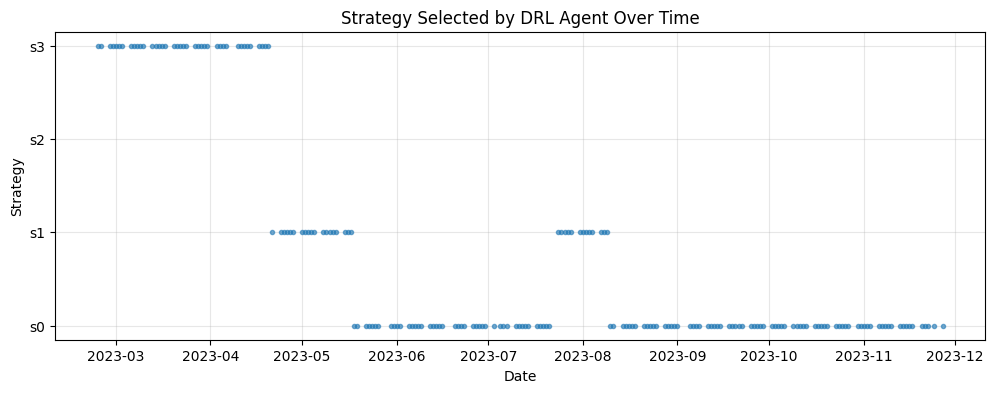


=== PERFORMANCE REPORT ===
Total Return: 0.4705%
Annualized Return: 0.6179%
Annualized Volatility: 17.90%
Sharpe Ratio: 0.0345
Sortino Ratio: 0.0447
Max Drawdown: 13.0252%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window0.csv

=== Processing Window 2/14 ===
Window 1: Train=(252, 1261), Val=(1261, 1512), Test=(1512, 1764)
Memory usage: 2.9%
Creating features for train set (indices 252:1261)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.    0.333 0.    0.    0.    0.    0.    0.333 0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.    0.333 0.    0.    0.333 0.   ] (sum=1.000)
Creating features for val

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=-1.408 | MDD=1.371

⚠️ Max drawdown 1.371 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6781790256500244 min = 0.6781790256500244 max = 0.6781790256500244
[Diag-After] grad on weight_log_std_raw: None
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window1.pkl
GPU memory after training:
GPU Memory allocated: 0.03 GB
GPU Memory cached: 1.30 GB
Window 1 test reward: -23.34
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window1.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window1.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window1.png


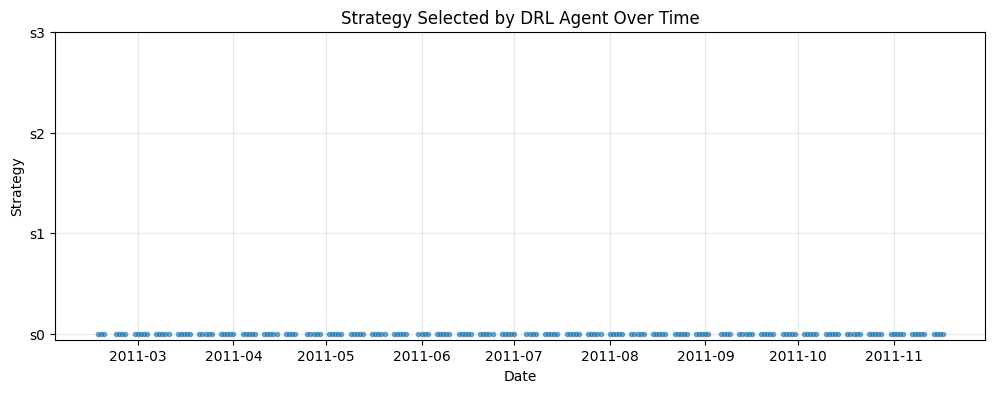


=== PERFORMANCE REPORT ===
Total Return: 0.1493%
Annualized Return: 0.1960%
Annualized Volatility: 31.16%
Sharpe Ratio: 0.0063
Sortino Ratio: 0.0096
Max Drawdown: 17.8430%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window1.csv

=== Processing Window 3/14 ===
Window 2: Train=(504, 1513), Val=(1513, 1764), Test=(1764, 2016)
Memory usage: 2.8%
Creating features for train set (indices 504:1513)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.    0.333 0.    0.    0.    0.    0.    0.333 0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.    0.333 0.    0.    0.333 0.   ] (sum=1.000)
Creating features for val

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=0.585 | MDD=0.542

⚠️ Max drawdown 0.542 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6781790256500244 min = 0.6781790256500244 max = 0.6781790256500244
[Diag-After] grad on weight_log_std_raw: None
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window2.pkl
GPU memory after training:
GPU Memory allocated: 0.03 GB
GPU Memory cached: 1.30 GB
Window 2 test reward: -17.99
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window2.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window2.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window2.png


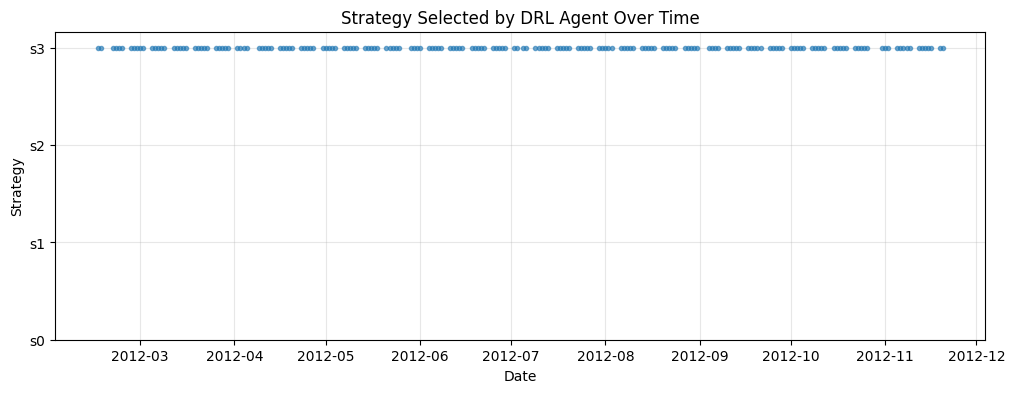


=== PERFORMANCE REPORT ===
Total Return: 0.3331%
Annualized Return: 0.4374%
Annualized Volatility: 13.13%
Sharpe Ratio: 0.0333
Sortino Ratio: 0.0473
Max Drawdown: 11.1506%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window2.csv

=== Processing Window 4/14 ===
Window 3: Train=(756, 1765), Val=(1765, 2016), Test=(2016, 2268)
Memory usage: 2.8%
Creating features for train set (indices 756:1765)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.    0.333 0.    0.    0.    0.    0.    0.333 0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.    0.333 0.    0.    0.333 0.   ] (sum=1.000)
Creating features for val

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=1.385 | MDD=0.119

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.365   |
|    adv_p05               | -0.983   |
|    adv_p95               | 0.271    |
|    adv_std               | 0.569    |
|    corr_value_vs_returns | 0.626    |
|    returns_mean          | -0.0234  |
|    returns_p05           | -0.848   |
|    returns_p95           | 0.717    |
|    returns_std           | 0.614    |
|    reward_mean           | -0.0578  |
|    reward_p05            | -0.082   |
|    reward_p95            | -0.0128  |
|    reward_sharpe         | -0.168   |
|    reward_std            | 0.345    |
| time/                    |          |
|    fps                   | 86       |
|    iterations            | 1        |
|    time_elapsed          | 11       |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.119    |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[KLDiag] cat=0.271, gauss=2.387, total=2.659

[Diag] t=2000 | Sharpe=-0.046 | MDD=0.482

⚠️ Max drawdown 0.482 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6869760751724243 min = 0.6670024991035461 max = 0.7061120271682739
[Diag-After] grad on weight_log_std_raw: (0.009820803999900818, -0.02025623433291912, 0.037519704550504684)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window3.pkl
GPU memory after training:
GPU Memory allocated: 0.04 GB
GPU Memory cached: 1.30 GB
Window 3 test reward: 17.87
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window3.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window3.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window3.png


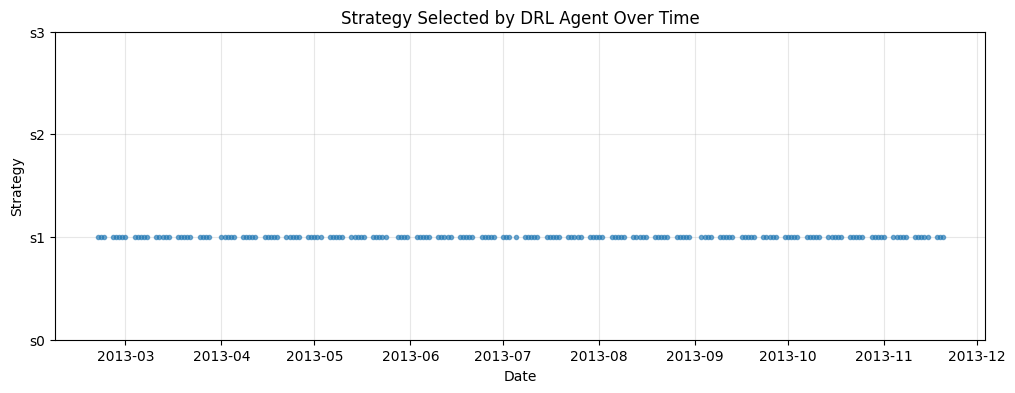


=== PERFORMANCE REPORT ===
Total Return: 0.5515%
Annualized Return: 0.7245%
Annualized Volatility: 14.86%
Sharpe Ratio: 0.0488
Sortino Ratio: 0.0616
Max Drawdown: 8.7277%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window3.csv

=== Processing Window 5/14 ===
Window 4: Train=(1008, 2017), Val=(2017, 2268), Test=(2268, 2520)
Memory usage: 2.8%
Creating features for train set (indices 1008:2017)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.    0.333 0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.    0.    0.    0.    0.333 0.333] (sum=1.000)
Creating features for va

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=3.698 | MDD=0.045

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.0491  |
|    adv_p05               | -0.8     |
|    adv_p95               | 0.538    |
|    adv_std               | 0.471    |
|    corr_value_vs_returns | 0.806    |
|    returns_mean          | -0.623   |
|    returns_p05           | -1.52    |
|    returns_p95           | 0.484    |
|    returns_std           | 0.631    |
|    reward_mean           | -0.0412  |
|    reward_p05            | -0.0899  |
|    reward_p95            | -0.0144  |
|    reward_sharpe         | -0.126   |
|    reward_std            | 0.327    |
| time/                    |          |
|    fps                   | 95       |
|    iterations            | 1        |
|    time_elapsed          | 10       |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.0445   |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[KLDiag] cat=0.255, gauss=1.427, total=1.682

[Diag] t=2000 | Sharpe=1.484 | MDD=0.207

No Sharpe improvement (1/5)

----------------------------------------
| critic/                  |           |
|    adv_mean              | 0.055     |
|    adv_p05               | -0.178    |
|    adv_p95               | 0.42      |
|    adv_std               | 0.204     |
|    corr_value_vs_returns | 0.946     |
|    returns_mean          | -0.752    |
|    returns_p05           | -1.34     |
|    returns_p95           | -0.389    |
|    returns_std           | 0.309     |
|    reward_mean           | -0.0396   |
|    reward_p05            | -0.042    |
|    reward_p95            | -0.0306   |
|    reward_sharpe         | -5.86     |
|    reward_std            | 0.00675   |
|    value_grad_norm       | 0.00966   |
| diag/                    |           |
|    adv_mean              | -0.0491   |
|    adv_std               | 0.471     |
|    cat_entropy           | 0.934     |
|    gauss_entropy         | 2.1       |
|    kl_cat                | 0.255     |
|    kl_gauss              | 1.43      |
|    kl_total   

[KLDiag] cat=0.646, gauss=1.060, total=1.706

[Diag] t=3000 | Sharpe=1.544 | MDD=0.524

⚠️ Max drawdown 0.524 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6759840250015259 min = 0.64580899477005 max = 0.6974918842315674
[Diag-After] grad on weight_log_std_raw: (0.002100080717355013, -0.02622327022254467, 0.04056093096733093)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window4.pkl
GPU memory after training:
GPU Memory allocated: 0.05 GB
GPU Memory cached: 1.30 GB
Window 4 test reward: 3.72
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window4.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window4.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window4.png


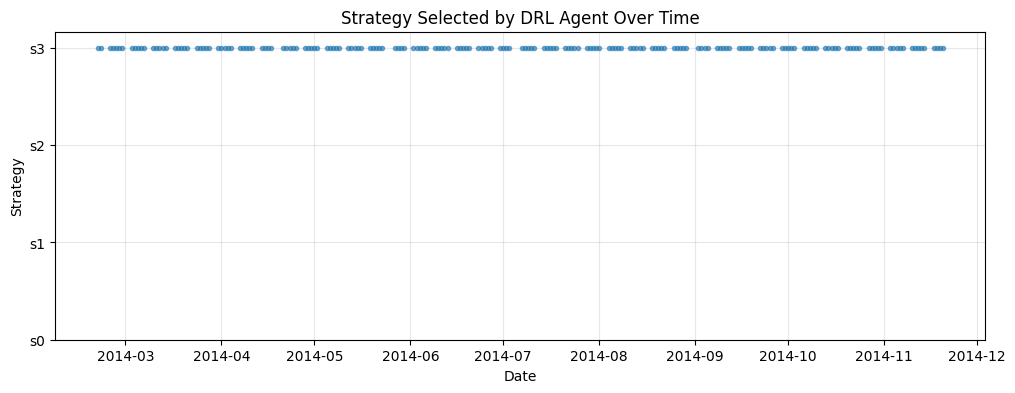


=== PERFORMANCE REPORT ===
Total Return: 0.2262%
Annualized Return: 0.2970%
Annualized Volatility: 18.66%
Sharpe Ratio: 0.0159
Sortino Ratio: 0.0177
Max Drawdown: 14.2489%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window4.csv

=== Processing Window 6/14 ===
Window 5: Train=(1260, 2269), Val=(2269, 2520), Test=(2520, 2772)
Memory usage: 2.8%
Creating features for train set (indices 1260:2269)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.    0.    0.    0.333 0.    0.    0.    0.    0.333] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.    0.    0.333 0.    0.    0.333] (sum=1.000)
Creating features for v

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=1.499 | MDD=0.261

---------------------------------------
| critic/                  |          |
|    adv_mean              | 0.0793   |
|    adv_p05               | -0.638   |
|    adv_p95               | 0.648    |
|    adv_std               | 0.475    |
|    corr_value_vs_returns | 0.576    |
|    returns_mean          | -0.925   |
|    returns_p05           | -1.5     |
|    returns_p95           | -0.326   |
|    returns_std           | 0.452    |
|    reward_mean           | -0.0442  |
|    reward_p05            | -0.0898  |
|    reward_p95            | 0.0205   |
|    reward_sharpe         | -0.132   |
|    reward_std            | 0.335    |
| time/                    |          |
|    fps                   | 85       |
|    iterations            | 1        |
|    time_elapsed          | 11       |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.261    |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[KLDiag] cat=0.191, gauss=1.474, total=1.665

[Diag] t=2000 | Sharpe=0.503 | MDD=0.177

No Sharpe improvement (1/5)

----------------------------------------
| critic/                  |           |
|    adv_mean              | -0.0523   |
|    adv_p05               | -0.322    |
|    adv_p95               | 0.215     |
|    adv_std               | 0.179     |
|    corr_value_vs_returns | 0.855     |
|    returns_mean          | -0.612    |
|    returns_p05           | -0.941    |
|    returns_p95           | -0.251    |
|    returns_std           | 0.213     |
|    reward_mean           | -0.0467   |
|    reward_p05            | -0.0567   |
|    reward_p95            | -0.00571  |
|    reward_sharpe         | -2.41     |
|    reward_std            | 0.0194    |
|    value_grad_norm       | 0.0187    |
| diag/                    |           |
|    adv_mean              | 0.0793    |
|    adv_std               | 0.475     |
|    cat_entropy           | 1.07      |
|    gauss_entropy         | 2.1       |
|    kl_cat                | 0.191     |
|    kl_gauss              | 1.47      |
|    kl_total   

[Diag] eval weight_log_std snapshot: 0.687330424785614

[KLDiag] cat=0.126, gauss=0.607, total=0.733

[Diag] t=3000 | Sharpe=2.443 | MDD=0.100

----------------------------------------
| critic/                  |           |
|    adv_mean              | -0.0178   |
|    adv_p05               | -0.197    |
|    adv_p95               | 0.127     |
|    adv_std               | 0.0974    |
|    corr_value_vs_returns | 0.926     |
|    returns_mean          | -0.629    |
|    returns_p05           | -0.824    |
|    returns_p95           | -0.353    |
|    returns_std           | 0.153     |
|    reward_mean           | -0.0431   |
|    reward_p05            | -0.0486   |
|    reward_p95            | -0.0226   |
|    reward_sharpe         | -3.79     |
|    reward_std            | 0.0114    |
|    value_grad_norm       | 0.0134    |
| diag/                    |           |
|    adv_mean              | -0.0523   |
|    adv_std               | 0.179     |
|    cat_entropy           | 1.17      |
|    gauss_entropy         | 2.11      |
|    kl_cat                | 0.126     |
|    kl_gauss              | 0.607     |
|    kl_total   

[KLDiag] cat=0.400, gauss=0.469, total=0.869

[Diag] t=4000 | Sharpe=1.427 | MDD=0.587

⚠️ Max drawdown 0.587 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6854376196861267 min = 0.6554638147354126 max = 0.7241659164428711
[Diag-After] grad on weight_log_std_raw: (0.0008781664073467255, -0.02944035455584526, 0.023663196712732315)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window5.pkl
GPU memory after training:
GPU Memory allocated: 0.05 GB
GPU Memory cached: 1.30 GB
Window 5 test reward: -40.39
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window5.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window5.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window5.png


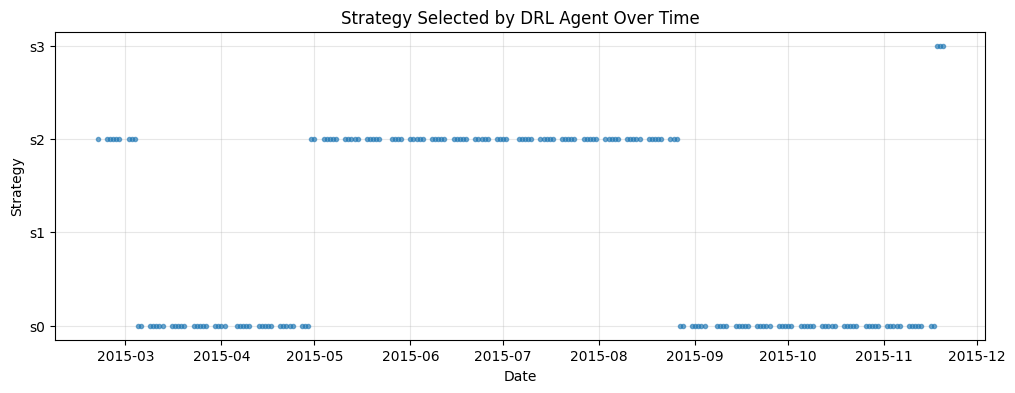


=== PERFORMANCE REPORT ===
Total Return: -0.6053%
Annualized Return: -0.7936%
Annualized Volatility: 18.77%
Sharpe Ratio: -0.0423
Sortino Ratio: -0.0734
Max Drawdown: 18.9595%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window5.csv

=== Processing Window 7/14 ===
Window 6: Train=(1512, 2521), Val=(2521, 2772), Test=(2772, 3024)
Memory usage: 2.8%
Creating features for train set (indices 1512:2521)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.    0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.    0.333 0.333 0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.    0.    0.    0.    0.    0.333 0.    0.    0.333] (sum=1.000)
Creating features f

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=2.729 | MDD=0.070

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.148   |
|    adv_p05               | -0.994   |
|    adv_p95               | 0.743    |
|    adv_std               | 0.709    |
|    corr_value_vs_returns | 0.622    |
|    returns_mean          | -0.431   |
|    returns_p05           | -1.39    |
|    returns_p95           | 0.308    |
|    returns_std           | 0.703    |
|    reward_mean           | -0.059   |
|    reward_p05            | -0.107   |
|    reward_p95            | -0.00484 |
|    reward_sharpe         | -0.182   |
|    reward_std            | 0.324    |
| time/                    |          |
|    fps                   | 85       |
|    iterations            | 1        |
|    time_elapsed          | 11       |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.0697   |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[KLDiag] cat=0.250, gauss=1.240, total=1.490

[Diag] t=2000 | Sharpe=1.826 | MDD=0.125

No Sharpe improvement (1/5)

----------------------------------------
| critic/                  |           |
|    adv_mean              | 0.0623    |
|    adv_p05               | -0.281    |
|    adv_p95               | 0.467     |
|    adv_std               | 0.244     |
|    corr_value_vs_returns | 0.873     |
|    returns_mean          | -0.724    |
|    returns_p05           | -1.27     |
|    returns_p95           | -0.3      |
|    returns_std           | 0.29      |
|    reward_mean           | -0.0367   |
|    reward_p05            | -0.0429   |
|    reward_p95            | -0.00108  |
|    reward_sharpe         | -2.32     |
|    reward_std            | 0.0158    |
|    value_grad_norm       | 0.00496   |
| diag/                    |           |
|    adv_mean              | -0.148    |
|    adv_std               | 0.709     |
|    cat_entropy           | 0.941     |
|    gauss_entropy         | 2.11      |
|    kl_cat                | 0.25      |
|    kl_gauss              | 1.24      |
|    kl_total   

[KLDiag] cat=0.374, gauss=0.734, total=1.107

[Diag] t=3000 | Sharpe=-1.099 | MDD=2.326

⚠️ Max drawdown 2.326 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6882873177528381 min = 0.6675556898117065 max = 0.7025202512741089
[Diag-After] grad on weight_log_std_raw: (0.0048582847230136395, -0.006590061821043491, 0.027517078444361687)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window6.pkl
GPU memory after training:
GPU Memory allocated: 0.05 GB
GPU Memory cached: 1.30 GB
Window 6 test reward: -5.11
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window6.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window6.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window6.png


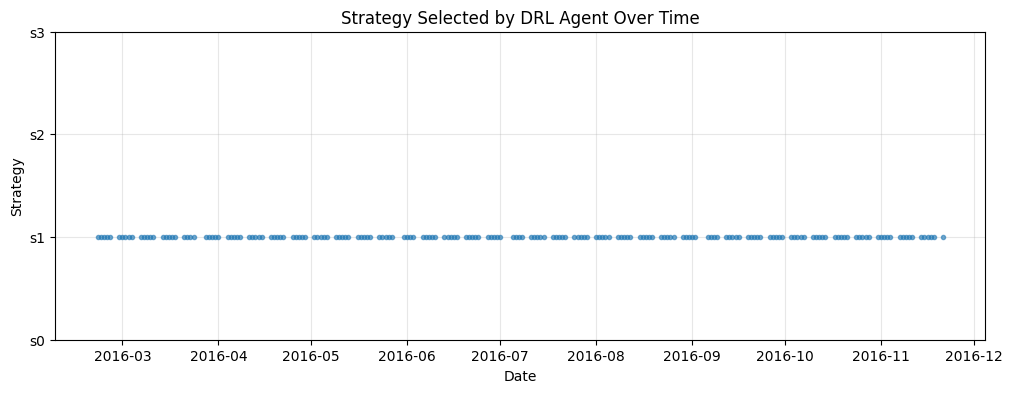


=== PERFORMANCE REPORT ===
Total Return: 2.1383%
Annualized Return: 2.8159%
Annualized Volatility: 23.06%
Sharpe Ratio: 0.1221
Sortino Ratio: 0.1407
Max Drawdown: 16.6446%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window6.csv

=== Processing Window 8/14 ===
Window 7: Train=(1764, 2773), Val=(2773, 3024), Test=(3024, 3276)
Memory usage: 2.8%
Creating features for train set (indices 1764:2773)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.333 0.    0.    0.    0.    0.    0.    0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.333 0.    0.    0.   ] (sum=1.000)
  - high_sharpe: [0.    0.    0.    0.    0.333 0.    0.333 0.    0.    0.333] (sum=1.000)
Creating features for v

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=0.882 | MDD=0.190

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.533   |
|    adv_p05               | -1.1     |
|    adv_p95               | 0.0224   |
|    adv_std               | 0.457    |
|    corr_value_vs_returns | 0.515    |
|    returns_mean          | 0.424    |
|    returns_p05           | -0.125   |
|    returns_p95           | 0.949    |
|    returns_std           | 0.437    |
|    reward_mean           | -0.0372  |
|    reward_p05            | -0.0927  |
|    reward_p95            | 0.00429  |
|    reward_sharpe         | -0.114   |
|    reward_std            | 0.327    |
| time/                    |          |
|    fps                   | 97       |
|    iterations            | 1        |
|    time_elapsed          | 10       |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.19     |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[Diag] eval weight_log_std snapshot: 0.6790739297866821

[Diag] eval weight_log_std snapshot: 0.6803088188171387

[Diag] eval weight_log_std snapshot: 0.6831077933311462

[Diag] eval weight_log_std snapshot: 0.683332085609436

[KLDiag] cat=0.270, gauss=1.071, total=1.341

[Diag] t=2000 | Sharpe=-0.027 | MDD=0.248

No Sharpe improvement (1/5)

----------------------------------------
| critic/                  |           |
|    adv_mean              | 0.142     |
|    adv_p05               | -0.343    |
|    adv_p95               | 0.606     |
|    adv_std               | 0.312     |
|    corr_value_vs_returns | 0.904     |
|    returns_mean          | -0.931    |
|    returns_p05           | -1.59     |
|    returns_p95           | -0.166    |
|    returns_std           | 0.408     |
|    reward_mean           | -0.0424   |
|    reward_p05            | -0.0475   |
|    reward_p95            | -0.0215   |
|    reward_sharpe         | -4.09     |
|    reward_std            | 0.0103    |
|    value_grad_norm       | 0.00813   |
| diag/                    |           |
|    adv_mean              | -0.533    |
|    adv_std               | 0.457     |
|    cat_entropy           | 1.12      |
|    gauss_entropy         | 2.1       |
|    kl_cat                | 0.27      |
|    kl_gauss              | 1.07      |
|    kl_total   

[KLDiag] cat=0.511, gauss=1.343, total=1.854

[Diag] t=3000 | Sharpe=-1.235 | MDD=4.660

⚠️ Max drawdown 4.660 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6871965527534485 min = 0.6700576543807983 max = 0.6995311379432678
[Diag-After] grad on weight_log_std_raw: (0.0026643250603228807, -0.021363163366913795, 0.020722271874547005)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window7.pkl
GPU memory after training:
GPU Memory allocated: 0.06 GB
GPU Memory cached: 1.30 GB
Window 7 test reward: -213.82
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window7.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window7.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window7.png


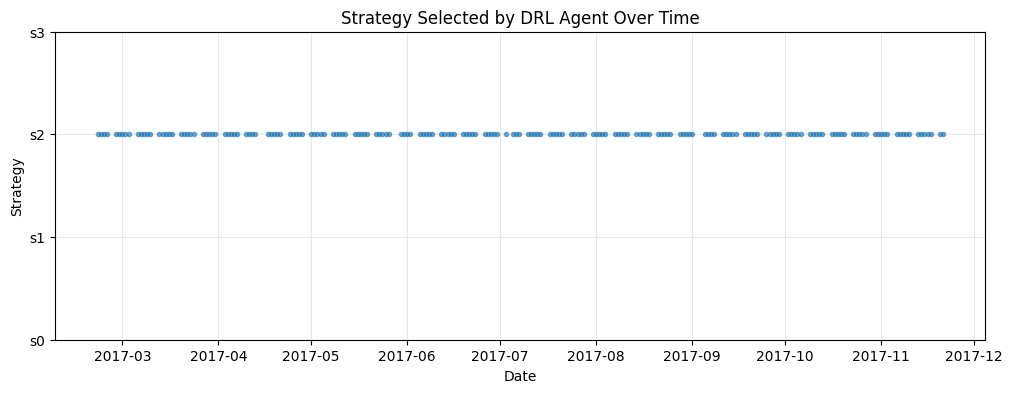


=== PERFORMANCE REPORT ===
Total Return: 1.6433%
Annualized Return: 2.1623%
Annualized Volatility: 65.02%
Sharpe Ratio: 0.0333
Sortino Ratio: 0.0377
Max Drawdown: 48.4218%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window7.csv

=== Processing Window 9/14 ===
Window 8: Train=(2016, 3025), Val=(3025, 3276), Test=(3276, 3528)
Memory usage: 2.8%
Creating features for train set (indices 2016:3025)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.    0.333 0.333 0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.333 0.    0.    0.   ] (sum=1.000)
  - high_sharpe: [0.    0.    0.    0.    0.333 0.    0.333 0.    0.    0.333] (sum=1.000)
Creating features for v

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=-0.134 | MDD=0.464

⚠️ Max drawdown 0.464 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6781790256500244 min = 0.6781790256500244 max = 0.6781790256500244
[Diag-After] grad on weight_log_std_raw: None
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window8.pkl
GPU memory after training:
GPU Memory allocated: 0.06 GB
GPU Memory cached: 1.30 GB
Window 8 test reward: -23.41
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window8.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window8.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window8.png


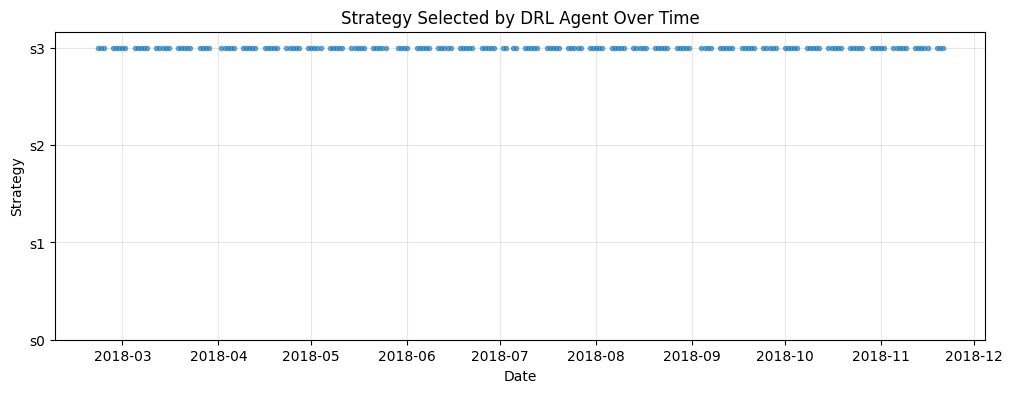


=== PERFORMANCE REPORT ===
Total Return: 0.1456%
Annualized Return: 0.1911%
Annualized Volatility: 18.54%
Sharpe Ratio: 0.0103
Sortino Ratio: 0.0160
Max Drawdown: 12.3663%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window8.csv

=== Processing Window 10/14 ===
Window 9: Train=(2268, 3277), Val=(3277, 3528), Test=(3528, 3780)
Memory usage: 2.8%
Creating features for train set (indices 2268:3277)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.333 0.    0.    0.    0.    0.    0.    0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.    0.333 0.    0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.333 0.    0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
Creating features for 

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=2.774 | MDD=0.047

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.121   |
|    adv_p05               | -0.728   |
|    adv_p95               | 0.457    |
|    adv_std               | 0.598    |
|    corr_value_vs_returns | 0.366    |
|    returns_mean          | -0.534   |
|    returns_p05           | -1.09    |
|    returns_p95           | 0.0146   |
|    returns_std           | 0.536    |
|    reward_mean           | -0.0587  |
|    reward_p05            | -0.101   |
|    reward_p95            | 0.0453   |
|    reward_sharpe         | -0.177   |
|    reward_std            | 0.332    |
| time/                    |          |
|    fps                   | 86       |
|    iterations            | 1        |
|    time_elapsed          | 11       |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.0468   |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[Diag] eval weight_log_std snapshot: 0.6782523393630981

[KLDiag] cat=0.218, gauss=1.073, total=1.291

[Diag] t=2000 | Sharpe=-1.353 | MDD=0.996

⚠️ Max drawdown 0.996 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.683804988861084 min = 0.6687963008880615 max = 0.6941673755645752
[Diag-After] grad on weight_log_std_raw: (-0.0028498019091784954, -0.02724478766322136, 0.01783956028521061)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window9.pkl
GPU memory after training:
GPU Memory allocated: 0.07 GB
GPU Memory cached: 1.30 GB
Window 9 test reward: -39.60
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window9.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window9.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window9.png


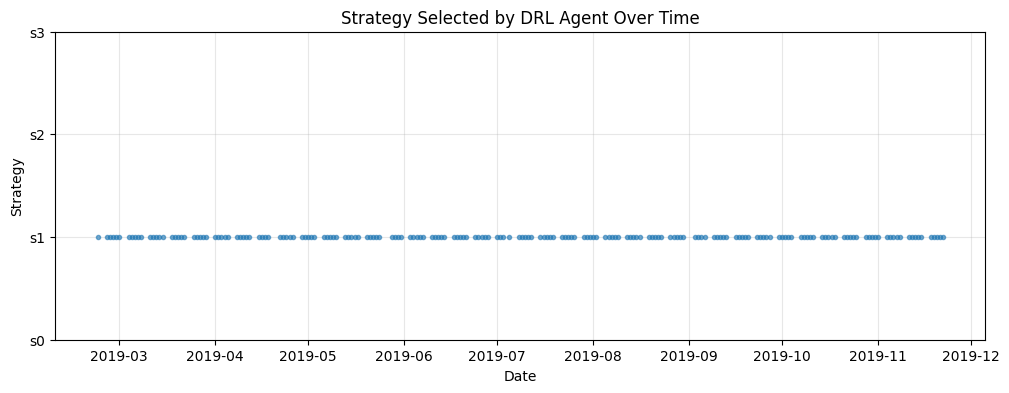


=== PERFORMANCE REPORT ===
Total Return: -0.6674%
Annualized Return: -0.8750%
Annualized Volatility: 50.60%
Sharpe Ratio: -0.0173
Sortino Ratio: -0.0203
Max Drawdown: 34.2833%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window9.csv

=== Processing Window 11/14 ===
Window 10: Train=(2520, 3529), Val=(3529, 3780), Test=(3780, 4032)
Memory usage: 2.9%
Creating features for train set (indices 2520:3529)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.333 0.    0.    0.    0.    0.    0.    0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.    0.    0.333 0.   ] (sum=1.000)
  - high_sharpe: [0.    0.333 0.333 0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
Creating features

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=1.721 | MDD=0.122

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.0294  |
|    adv_p05               | -0.684   |
|    adv_p95               | 0.5      |
|    adv_std               | 0.573    |
|    corr_value_vs_returns | 0.6      |
|    returns_mean          | -0.75    |
|    returns_p05           | -1.27    |
|    returns_p95           | 0.143    |
|    returns_std           | 0.638    |
|    reward_mean           | -0.0624  |
|    reward_p05            | -0.0879  |
|    reward_p95            | 0.00526  |
|    reward_sharpe         | -0.184   |
|    reward_std            | 0.338    |
| time/                    |          |
|    fps                   | 104      |
|    iterations            | 1        |
|    time_elapsed          | 9        |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.122    |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[KLDiag] cat=0.200, gauss=1.269, total=1.469

[Diag] t=2000 | Sharpe=2.504 | MDD=0.132

----------------------------------------
| critic/                  |           |
|    adv_mean              | -0.0364   |
|    adv_p05               | -0.597    |
|    adv_p95               | 0.309     |
|    adv_std               | 0.29      |
|    corr_value_vs_returns | 0.893     |
|    returns_mean          | -0.509    |
|    returns_p05           | -0.893    |
|    returns_p95           | 0.401     |
|    returns_std           | 0.339     |
|    reward_mean           | -0.0374   |
|    reward_p05            | -0.0491   |
|    reward_p95            | 0.00782   |
|    reward_sharpe         | -1.88     |
|    reward_std            | 0.0199    |
|    value_grad_norm       | 0.00452   |
| diag/                    |           |
|    adv_mean              | -0.0294   |
|    adv_std               | 0.573     |
|    cat_entropy           | 0.895     |
|    gauss_entropy         | 2.1       |
|    kl_cat                | 0.2       |
|    kl_gauss              | 1.27      |
|    kl_total   

[KLDiag] cat=0.271, gauss=0.530, total=0.802

[Diag] t=3000 | Sharpe=0.905 | MDD=0.374

⚠️ Max drawdown 0.374 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6935054659843445 min = 0.6730040311813354 max = 0.7082570195198059
[Diag-After] grad on weight_log_std_raw: (-0.009710603393614292, -0.04148465767502785, 0.03924145922064781)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window10.pkl
GPU memory after training:
GPU Memory allocated: 0.05 GB
GPU Memory cached: 1.30 GB
Window 10 test reward: -39.82
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window10.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window10.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window10.png


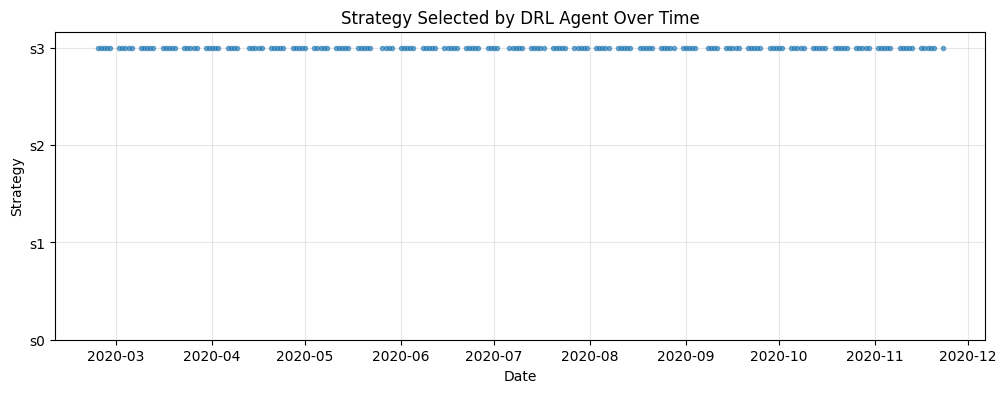


=== PERFORMANCE REPORT ===
Total Return: 7.2269%
Annualized Return: 9.5907%
Annualized Volatility: 58.32%
Sharpe Ratio: 0.1644
Sortino Ratio: 0.2522
Max Drawdown: 36.6291%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window10.csv

=== Processing Window 12/14 ===
Window 11: Train=(2772, 3781), Val=(3781, 4032), Test=(4032, 4284)
Memory usage: 2.8%
Creating features for train set (indices 2772:3781)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.333 0.    0.    0.    0.    0.    0.    0.   ] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.    0.    0.333 0.   ] (sum=1.000)
  - high_sharpe: [0.    0.333 0.333 0.    0.    0.    0.    0.333 0.    0.   ] (sum=1.000)
Creating features fo

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=-0.244 | MDD=0.422

⚠️ Max drawdown 0.422 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6781790256500244 min = 0.6781790256500244 max = 0.6781790256500244
[Diag-After] grad on weight_log_std_raw: None
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window11.pkl
GPU memory after training:
GPU Memory allocated: 0.04 GB
GPU Memory cached: 1.30 GB
Window 11 test reward: -41.70
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window11.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window11.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window11.png


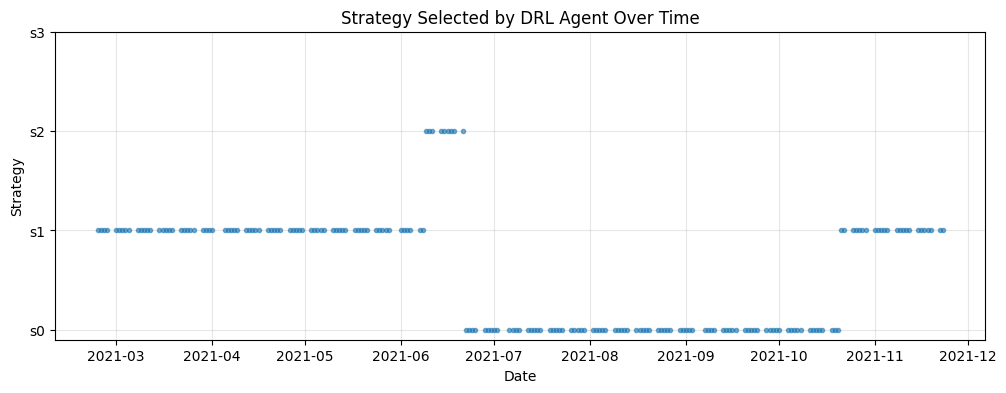


=== PERFORMANCE REPORT ===
Total Return: -0.8651%
Annualized Return: -1.1339%
Annualized Volatility: 25.28%
Sharpe Ratio: -0.0449
Sortino Ratio: -0.0670
Max Drawdown: 15.9175%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window11.csv

=== Processing Window 13/14 ===
Window 12: Train=(3024, 4033), Val=(4033, 4284), Test=(4284, 4536)
Memory usage: 2.9%
Creating features for train set (indices 3024:4033)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.    0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.    0.    0.333 0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.333 0.    0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
Creating feature

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=-1.295 | MDD=0.531

⚠️ Max drawdown 0.531 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6781790256500244 min = 0.6781790256500244 max = 0.6781790256500244
[Diag-After] grad on weight_log_std_raw: None
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window12.pkl
GPU memory after training:
GPU Memory allocated: 0.04 GB
GPU Memory cached: 1.30 GB
Window 12 test reward: -67.89
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window12.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window12.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window12.png


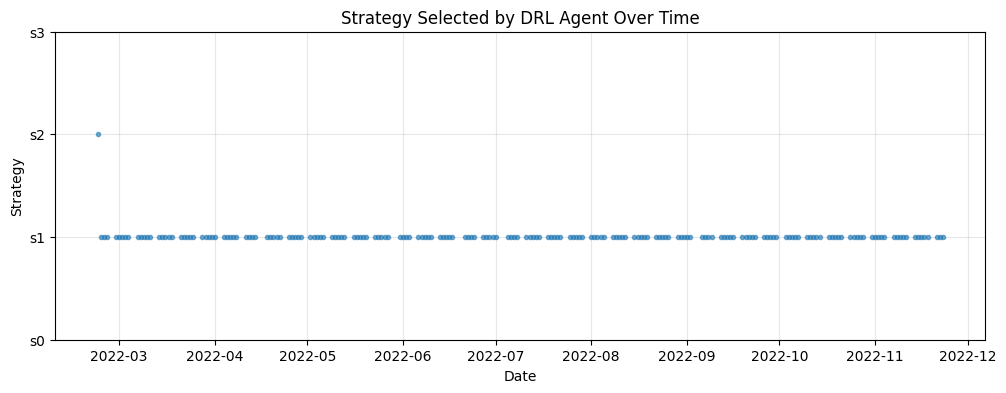


=== PERFORMANCE REPORT ===
Total Return: 13.8383%
Annualized Return: 18.5437%
Annualized Volatility: 960467.14%
Sharpe Ratio: 0.0000
Sortino Ratio: 0.1581
Max Drawdown: 99.9921%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window12.csv

=== Processing Window 14/14 ===
Window 13: Train=(3276, 4285), Val=(4285, 4536), Test=(4536, 4788)
Memory usage: 2.9%
Creating features for train set (indices 3276:4285)...
Calculating training correlation matrix and betas...
Training correlation and beta calculation complete.
Defining combinatorial strategies using train data...
Defined 4 base strategies:
  - equal_weight: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] (sum=1.000)
  - momentum: [0.333 0.333 0.    0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
  - low_vol: [0.    0.    0.    0.    0.333 0.333 0.    0.    0.333 0.   ] (sum=1.000)
  - high_sharpe: [0.333 0.333 0.    0.    0.    0.    0.    0.    0.    0.333] (sum=1.000)
Creating featu

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

[Diag] t=1000 | Sharpe=0.630 | MDD=0.255

---------------------------------------
| critic/                  |          |
|    adv_mean              | -0.228   |
|    adv_p05               | -0.895   |
|    adv_p95               | 0.324    |
|    adv_std               | 0.55     |
|    corr_value_vs_returns | 0.645    |
|    returns_mean          | -0.265   |
|    returns_p05           | -0.914   |
|    returns_p95           | 0.573    |
|    returns_std           | 0.567    |
|    reward_mean           | -0.0541  |
|    reward_p05            | -0.0811  |
|    reward_p95            | -0.00502 |
|    reward_sharpe         | -0.155   |
|    reward_std            | 0.35     |
| time/                    |          |
|    fps                   | 105      |
|    iterations            | 1        |
|    time_elapsed          | 9        |
|    total_timesteps       | 1024     |
| train/                   |          |
|    max_drawdown          | 0.255    |
|    policy_std_default    | 1        |
|    policy_std_max        | 1.97     |


[KLDiag] cat=0.374, gauss=1.108, total=1.482

[Diag] t=2000 | Sharpe=1.634 | MDD=0.373

⚠️ Max drawdown 0.373 > 0.350 — stopping.

[Diag-Before] weight_log_std_raw values: mean = 0.6824705004692078 min = 0.6744369864463806 max = 0.6914665699005127
[Diag-After] grad on weight_log_std_raw: (-0.006241169758141041, -0.03755287453532219, 0.03378608822822571)
Saved VecNormalize stats to /content/drive/MyDrive/trader/outputs/vecnormalize_window13.pkl
GPU memory after training:
GPU Memory allocated: 0.05 GB
GPU Memory cached: 1.30 GB
Window 13 test reward: -32.93
Model saved: /content/drive/MyDrive/trader/outputs/models/portfolio_model_window13.zip
Saved performance figure: /content/drive/MyDrive/trader/outputs/figures/performance_window13.png
Saved diagnostics figure: /content/drive/MyDrive/trader/outputs/figures/diagnostics_window13.png


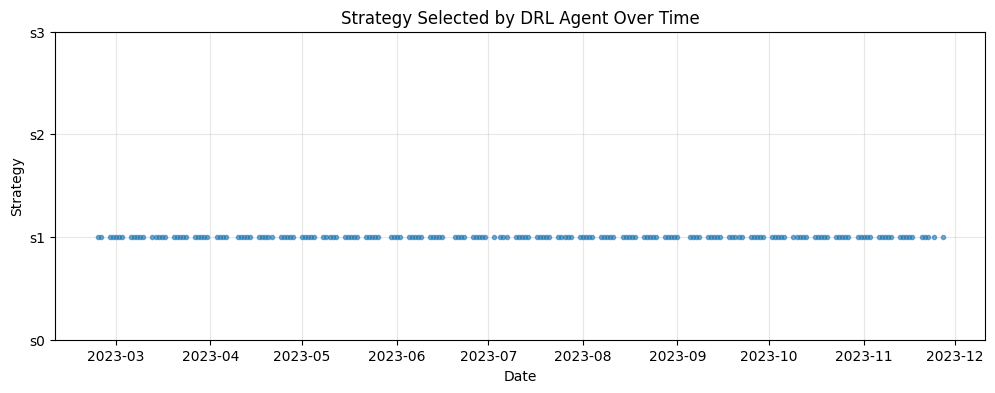


=== PERFORMANCE REPORT ===
Total Return: 2.9755%
Annualized Return: 3.9234%
Annualized Volatility: 50.39%
Sharpe Ratio: 0.0779
Sortino Ratio: 0.0896
Max Drawdown: 37.9343%
Final Value: $1,000,000.00
Saved results: /content/drive/MyDrive/trader/outputs/results/results_window13.csv
=== CROSS-WINDOW SHARPE SUMMARY ===
Empty DataFrame
Columns: []
Index: []

=== WALK-FORWARD ANALYSIS RESULTS ===
Mean test reward across all windows: -37.9709
Stddev of test rewards: 53.1706


In [ ]:
# ======== MAIN EXECUTION (LIGHT WFA) ========
if __name__ == "__main__":

    #torch.cuda.empty_cache()  # Clear GPU memory
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(f"Using device: {device}")
    #if torch.cuda.is_available():
        #print(f"GPU: {torch.cuda.get_device_name(0)}")
        #print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1024**3:.2f} GB")
    print("Processing data...")

    # Initialize with expanded date range (2005-2023 covers 2008 crash + COVID)
    processor = PortfolioDataProcessor(
        tickers=["AAPL", "MSFT", "JPM", "XOM", "SPY", "TLT", "JNJ", "PG", "GLD", "QQQ"],
        start_date="1999-01-01",
        end_date="2023-12-31",
        window_size=252*5,   # 5 years training
        step_size=252,       # 1 year test
        train_ratio=0.8,     # 80% train, 20% val within training window
    )

    # Download and process data
    processor.download_data()
    processor.validate_data()
    processor.compute_risk_metrics()
    processor.generate_walk_forward_windows()

    all_test_rewards = []
    best_params = None  # Store Optuna best parameters

    # ======== YEAR-BASED CROSS VALIDATION LOOP ========
    RUN_YEAR_CV = False  # set False to use your existing walk-forward loop

    if RUN_YEAR_CV:
        features = processor.create_full_features()
        raw_returns = processor.returns
        raw_volumes = processor.volumes
        folds = year_folds_from_index(features)

        for train_idx, val_idx, year in folds:
            print(f"=== Training fold: hold out {year} ===")

            # Slice using positions (keeps alignment with returns/volumes)
            train_features = features.iloc[train_idx]
            train_returns = raw_returns.iloc[train_idx]
            train_volumes = raw_volumes.iloc[train_idx]

            val_features = features.iloc[val_idx]
            val_returns = raw_returns.iloc[val_idx]
            val_volumes = raw_volumes.iloc[val_idx]
            processor.define_combinatorial_strategies(split='train', n_top_assets=3)

            model = train_portfolio_model(
                train_features,
                train_returns,
                train_volumes,
                processor.tickers,
                processor.strategy_list,
                val_features,
                val_returns,
                val_volumes,
                algorithm="PPO",
                timesteps=50000,
                window_idx=year  # ← uses year to keep VecNormalize files/logs separate
            )

            model.save(os.path.join(OUTPUT_DIR, f"model_yearcv_{year}.zip"))

    # ======================= WALK-FORWARD ANALYSIS =======================
    else:
        all_sharpes = []

        for window_idx in range(len(processor.walk_forward_windows)):
            print(f"\n=== Processing Window {window_idx + 1}/{len(processor.walk_forward_windows)} ===")

            # Set indices for this rolling window
            processor.set_window_indices(window_idx)
            print(f"Memory usage: {psutil.virtual_memory().percent}%")

            # Create features
            train_features = processor.create_features(split='train')
            processor.define_combinatorial_strategies(split='train', n_top_assets=3)
            val_features = processor.create_features(split='val')
            test_features = processor.create_features(split='test')

            # Raw returns/volumes
            train_raw_returns = processor.returns.loc[train_features.index]
            val_raw_returns = processor.returns.loc[val_features.index]
            test_raw_returns = processor.returns.loc[test_features.index]

            train_raw_volumes = processor.volumes.loc[train_features.index]
            val_raw_volumes = processor.volumes.loc[val_features.index]
            test_raw_volumes = processor.volumes.loc[test_features.index]

            if window_idx == 0:
                # Run Optuna once on the first window
                best_params = run_optuna(
                    train_features, train_raw_returns, train_raw_volumes,
                    val_features, val_raw_returns, val_raw_volumes,
                    processor.tickers, processor.strategy_list, n_trials=30
                )
            else:
                # Reuse the saved best params
                best_params = load_best_params(OUTPUT_DIR)

            # ========= VALIDATION CHECK =========
            print(f"Train features: {len(train_features)}, returns: {len(train_raw_returns)}, volumes: {len(train_raw_volumes)}")
            print(f"Val features: {len(val_features)}, returns: {len(val_raw_returns)}, volumes: {len(val_raw_volumes)}")
            print(f"Test features: {len(test_features)}, returns: {len(test_raw_returns)}, volumes: {len(test_raw_volumes)}")

            assert len(train_features) == len(train_raw_returns) == len(train_raw_volumes), "Train data misaligned!"
            assert len(val_features) == len(val_raw_returns) == len(val_raw_volumes), "Val data misaligned!"
            assert len(test_features) == len(test_raw_returns) == len(test_raw_volumes), "Test data misaligned!"

            if all_sharpes:
                mean_sharpe = np.mean(all_sharpes)
                print("\n=== AGGREGATED SHARPE RESULTS ===")
                print(f"Per-window Sharpes: {all_sharpes}")
                print(f"Average Sharpe: {mean_sharpe:.4f}")

            # ========= BENCHMARKS =========
            print("\n--- Running Benchmark Strategies ---")
            benchmark_tester = BenchmarkTester(processor, test_features, test_raw_returns, test_raw_volumes)
            benchmark_tester.run_benchmarks()

            # ======== OPTUNA STORAGE SETUP ========
            def setup_optuna_storage():
                """Create and return proper Optuna storage with directory creation"""
                optuna_dir = os.path.join(OUTPUT_DIR, "optuna")
                os.makedirs(optuna_dir, exist_ok=True)  # Ensure directory exists

                db_path = os.path.join(optuna_dir, "optuna_studies.db")
                storage_url = f"sqlite:///{db_path}"

                # Test if we can create/write to the database
                try:
                    import sqlite3
                    conn = sqlite3.connect(db_path)
                    conn.close()
                    print(f"Optuna storage ready: {db_path}")
                    return storage_url
                except Exception as e:
                    print(f"Warning: Could not create SQLite database at {db_path}: {e}")
                    # Fallback to in-memory storage
                    return "sqlite:///:memory:"

            #======== TRAIN FINAL MODEL WITH BEST PARAMS ========
            final_model = train_portfolio_model(
                train_features,
                train_raw_returns,
                train_raw_volumes,
                processor.tickers,
                processor.strategy_list,
                val_features,
                val_raw_returns,
                val_raw_volumes,
                timesteps=50000,
                window_idx=window_idx,
                policy_kwargs_override=best_params.get("policy_kwargs", {}),
                ppo_kwargs_override=best_params.get("ppo_kwargs", {}),
            )
            model = final_model

            # ======== EVALUATE ON TEST SET ========
            def make_test_env():
                return PortfolioOptimizationEnv(
                    test_features.values,
                    test_raw_returns.values,
                    test_raw_volumes.values,
                    tickers=processor.tickers,
                    initial_balance=1e6,
                    risk_free_rate=0.02,
                    lookback=30,
                    history_window=60,
                    strategy_list=processor.strategy_list,
                    reward_params={
                        "ema_alpha": 0.02,
                        "vol_floor": 1e-4,
                        "lambda_dd": 0.5,
                        "lambda_tc": 1.0,
                        "lambda_div": 0.05,
                        "lambda_smooth": 0.1,
                        "max_weight_cap": 0.25,
                        "lambda_corr": 0.05
                    }
                )

            test_env = DummyVecEnv([lambda: Monitor(make_test_env())])
            test_env = VecNormalize(test_env, training=False)


            stats_path = os.path.join(OUTPUT_DIR, f"vecnormalize_window{window_idx}.pkl")
            test_env = load_vecnormalize_for_eval(test_env, stats_path)

            mean_reward, _ = evaluate_policy(model, test_env, n_eval_episodes=3, deterministic=True)
            all_test_rewards.append(mean_reward)
            print(f"Window {window_idx} test reward: {mean_reward:.2f}")

            # ======== SAVE MODEL ========
            model_dir = os.path.join(OUTPUT_DIR, "models")
            os.makedirs(model_dir, exist_ok=True)
            model_path = os.path.join(model_dir, f"portfolio_model_window{window_idx}")
            model.save(model_path)   # SB3 will append .zip
            print(f"Model saved: {model_path}.zip")

            # ======== VISUALIZE RESULTS ========
            visualizer = PortfolioVisualizer(test_env, model, processor, window_idx=window_idx)

            visualizer.plot_performance()
            visualizer.plot_strategy_usage()
            visualizer.print_report()
            sharpe_ratio = visualizer.results.get("Sharpe Ratio", None)
            if sharpe_ratio is not None:
                all_sharpes.append(sharpe_ratio)
                print(f"Window {window_idx} Sharpe Ratio: {sharpe_ratio:.4f}")

            # ======== SAVE RESULTS CSV ========
            if visualizer is not None and hasattr(visualizer, 'results'):
                results_path = os.path.join(
                    OUTPUT_DIR, "results",
                    f"results_window{getattr(visualizer, 'window_idx', '0')}.csv"
                )
                try:
                    pd.DataFrame(visualizer.results).to_csv(results_path, index=False)
                    print("Saved results:", results_path)
                except Exception as e:
                    print("Failed to save results CSV:", e)
                finally:
                    # Ensure environments are closed
                    if 'test_env' in locals():
                        test_env.close()
                    if 'final_env' in locals():
                        final_env.close()
                    if 'eval_env' in locals():
                        eval_env.close()

            # === COLLECT CROSS-WINDOW SHARPE ===
            if "all_window_sharpes" not in globals():
                all_window_sharpes = []

            if hasattr(visualizer, "results") and "Sharpe Ratio" in visualizer.results:
                all_window_sharpes.append({
                    "window": window_idx,
                    "sharpe": visualizer.results["Sharpe Ratio"]
                })


            # After final window, save summary
            if window_idx == len(processor.walk_forward_windows) - 1:
                sharpe_df = pd.DataFrame(all_window_sharpes)
                sharpe_path = os.path.join(OUTPUT_DIR, "results", "cross_window_sharpes.csv")
                os.makedirs(os.path.join(OUTPUT_DIR, "results"), exist_ok=True)
                sharpe_df.to_csv(sharpe_path, index=False)
                print(f"=== CROSS-WINDOW SHARPE SUMMARY ===\n{sharpe_df}")

        # ======== FINAL SUMMARY ACROSS ALL WINDOWS ========
        print("\n=== WALK-FORWARD ANALYSIS RESULTS ===")
        print(f"Mean test reward across all windows: {np.mean(all_test_rewards):.4f}")
        print(f"Stddev of test rewards: {np.std(all_test_rewards):.4f}")


In [ ]:
# ======== COMPARATIVE EXPERIMENT FUNCTIONS ========
def run_comparative_experiment(processor, window_idx, experiment_type):
    """
    Run comparative experiments: hybrid, continuous-only, discrete-only
    """
    processor.set_window_indices(window_idx)

    # Create features
    train_features = processor.create_features(split='train')
    processor.define_combinatorial_strategies(split='train', n_top_assets=3)
    val_features = processor.create_features(split='val')
    test_features = processor.create_features(split='test')

    # Raw returns/volumes
    train_raw_returns = processor.returns.loc[train_features.index]
    val_raw_returns = processor.returns.loc[val_features.index]
    test_raw_returns = processor.returns.loc[test_features.index]
    train_raw_volumes = processor.volumes.loc[train_features.index]
    val_raw_volumes = processor.volumes.loc[val_features.index]
    test_raw_volumes = processor.volumes.loc[test_features.index]

    # Modify environment based on experiment type
    def make_env(features, raw_returns, raw_volumes, training_mode=False):
        if experiment_type == "continuous_only":
            # No base strategies - learn weights from scratch
            strategy_list = [np.ones(len(processor.tickers)) / len(processor.tickers)]  # Just equal weight
        elif experiment_type == "discrete_only":
            # No adjustments - just select strategies
            strategy_list = processor.strategy_list
        else:  # hybrid
            strategy_list = processor.strategy_list

        return PortfolioOptimizationEnv(
            features.values,
            raw_returns.values,
            raw_volumes.values,
            tickers=processor.tickers,
            initial_balance=1e6,
            transaction_cost=0.001,
            risk_free_rate=0.02,
            lookback=30,
            history_window=60,
            strategy_list=strategy_list,
            training_mode=training_mode,
            experiment_type=experiment_type  # Pass experiment type to env
        )
    # ====== VECNORMALIZE EVAL LOADER ======
    def load_vecnormalize_for_eval(venv, stats_path: str):
        """
        Load VecNormalize stats (obs_rms, ret_rms) into an existing VecEnv and set to eval mode.
        stats_path should point to the VecNormalize .pkl saved for the same window.
        """
        from stable_baselines3.common.vec_env import VecNormalize
        import os, pickle

        if not os.path.exists(stats_path):
            print(f"[WARN] VecNormalize stats not found at {stats_path}. Proceeding without.")
            return venv

        try:
            with open(stats_path, "rb") as f:
                saved = pickle.load(f)
            if isinstance(venv, VecNormalize):
                venv.obs_rms = saved.obs_rms
                venv.ret_rms = saved.ret_rms
                venv.training = False
                venv.clip_obs = saved.clip_obs
                venv.clip_reward = saved.clip_reward
                venv.epsilon = saved.epsilon
            else:
                # Wrap if needed
                venv = VecNormalize(venv, training=False)
                venv.obs_rms = saved.obs_rms
                venv.ret_rms = saved.ret_rms
                venv.training = False
            print("[INFO] Loaded VecNormalize stats for evaluation.")
        except Exception as e:
            print(f"[WARN] Failed to load VecNormalize stats: {e}")
        return venv


    # Train model
    env = DummyVecEnv([lambda: make_env(train_features, train_raw_returns, train_raw_volumes, True)])
    # Verify action space dimension consistency
    tmp_env = make_env(train_features, train_raw_returns, train_raw_volumes, True)
    expected_action_dim = (
        len(processor.tickers) + 1 if experiment_type == "hybrid"
        else (len(processor.tickers) if experiment_type == "continuous_only" else 1)
    )
    assert tmp_env.action_space.shape[0] == expected_action_dim, (
        f"env.action_space {tmp_env.action_space.shape} != expected {expected_action_dim}"
    )
    tmp_env.close()

    eval_env = DummyVecEnv([lambda: Monitor(make_env(val_features, val_raw_returns, val_raw_volumes, False))])
    eval_env = VecNormalize(eval_env, training=False)


    # Load stats for this window (adjust path format to your saving logic)
    stats_path = os.path.join(OUTPUT_DIR, f"vecnormalize_window{window_idx}.pkl")
    eval_env = load_vecnormalize_for_eval(eval_env, stats_path)

    model = train_portfolio_model(
        train_features, train_raw_returns, train_raw_volumes,
        processor.tickers, processor.strategy_list,
        val_features, val_raw_returns, val_raw_volumes
    )

    # Evaluate
    test_env = Monitor(make_env(test_features, test_raw_returns, test_raw_volumes, False))
    mean_reward, _ = evaluate_policy(model, test_env, n_eval_episodes=3, deterministic=True)

    # Collect metrics
    visualizer = PortfolioVisualizer(test_env, model, processor,window_idx=window_idx)
    metrics = visualizer.calculate_metrics()

    return {
        'experiment_type': experiment_type,
        'mean_reward': mean_reward,
        'metrics': metrics,
        'model': model
    }

In [ ]:
# === Diagnostics AFTER training ===
with torch.no_grad():
    if hasattr(model.policy, "weight_log_std"):
        wls = model.policy.weight_log_std
        print("[Diag-After] weight_log_std values:",
              "mean =", wls.mean().item(),
              "min =", wls.min().item(),
              "max =", wls.max().item())
    else:
        print("[Diag-After] No weight_log_std found in policy.")


[Diag-After] weight_log_std values: mean = 0.6824705004692078 min = 0.6744369864463806 max = 0.6914665699005127
